# IAU Project - Preprocessing

**Authors:** Peter Mačinec, Lukáš Janík

## Setup and import libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

# images
from IPython.display import Image

# hiding warnings for better appereance (this was added after checking all warnings)
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

## Additional functions definitions

Definition of additional functions for visualization of changes in preprocessing:

In [2]:
def data_normalization_compare(before, normalized, removed_outliers, replaced_outliers):
    """Function to compare data before normalization, after normalization and after removing outliers."""
    plt.rcParams['figure.figsize'] = (14, 4)

    plt.subplot(1, 4, 1)
    before.plot(kind='hist', bins=50)
    plt.title('Before normalization')

    plt.subplot(1, 4, 2)
    normalized.plot(kind='hist', bins=50)
    plt.title('After normalization')

    plt.subplot(1, 4, 3)
    removed_outliers.plot(kind='hist', bins=50)
    plt.title('Removing outliers')

    plt.subplot(1, 4, 4)
    replaced_outliers.plot(kind='hist', bins=50)
    plt.title('Replacing outliers')

    plt.tight_layout()

In [3]:
def compare_outliers(before, removed, replaced, columns):
    """Function to compare attribute values before removing and after removing outliers."""
    plt.rcParams['figure.figsize'] = (8, 14)
    
    i = 1
    rows = len(columns)
    for column in columns:
        
        plt.subplot(rows, 3, i)
        sns.boxplot(before[column])
        if i == 1:
            plt.title('Before')
       
        plt.subplot(rows, 3, i + 1)
        sns.boxplot(removed[column])
        if i == 1:
            plt.title('Removing outliers')
        
        plt.subplot(rows, 3, i + 2)
        sns.boxplot(replaced[column])
        if i == 1:
            plt.title('Replacing outliers')
        
        i += 3

    plt.tight_layout()

In [4]:
def compare_distributions(before, aggregation, model):
    """Function to compare categorical data before filling, after filling using aggregation and using model."""
    plt.rcParams['figure.figsize'] = (16, 6)
    
    plt.subplot(1, 3, 1)
    before.fillna('NaN').value_counts().plot(kind='bar')
    plt.title('Before filling')

    plt.subplot(1, 3, 2)
    aggregation.fillna('NaN').value_counts().plot(kind='bar')
    plt.title('After filling using most frequent value')

    plt.subplot(1, 3, 3)
    model.fillna('NaN').value_counts().plot(kind='bar')
    plt.title('After filling using model')

    plt.tight_layout()

In [5]:
def compare_filling(before, aggregation, model):
    """Function to compare numerical data before filling, after filling using aggregation and using model."""
    plt.rcParams['figure.figsize'] = (10, 4)

    plt.subplot(1, 3, 1)
    before.plot(kind='hist', bins=50)
    plt.title('Before filling')

    plt.subplot(1, 3, 2)
    aggregation.plot(kind='hist', bins=50)
    plt.title('After filling using median')

    plt.subplot(1, 3, 3)
    model.plot(kind='hist', bins=50)
    plt.title('After filling using model')

    plt.tight_layout()

## Read the data

Data are divided into two files, personal and other, so we need to read both of them:

In [6]:
# read datasets
df1 = pd.read_csv('data/personal_train.csv', index_col=0)
df2 = pd.read_csv('data/other_train.csv', index_col=0)

df1_valid = pd.read_csv('data/personal_valid.csv', index_col=0)
df2_valid = pd.read_csv('data/other_valid.csv', index_col=0)

## Preprocessing

As we have seen in previous analysis, our data need to be repaired, some values need to be filled, etc. Before putting data into model to predict **class**, whether is patient ill or not, data should be preprocessed. For this purposes, we will use Pipelines. Whole process is captured in three steps, **data repairing**, **data normalization and removing outliers** and at last, **filling nan values**.

### Merge datasets

At first, we need to merge both datasets into one. In previous analysis, we found that name and address would be used for merging:

In [7]:
df_train = pd.merge(df1, df2, on=["name", "address"])

In descriptive analysis, we found some duplicates in dataset with medical information. We need to merge their values and drop duplicated rows later.

### Data repairing

We know from a previous analysis that some data need to be repaired. Some columns have one value represented by more strings, another case is that column holds several values that need to be expanded, etc. In this section, data will be repaired at first so missing values would be replaced in next step.

All operations will be done using **Pipelines**, so whole preprocessing process will be reusable.

#### Merge and drop duplicates

As mentioned before, there are some duplicates. Let's check them:

In [8]:
duplicates = df_train[df_train.duplicated(['name', 'address'], keep='first')].sort_values('name')

In [9]:
duplicates.head()

,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,TT4,...,personal_info,T3 measured,on antithyroid medication,referral source,education-num,psych,occupation,TBG measured,TBG,pregnant
1656,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,1960-11-02,f,t,t,f,82.0,...,NaN,f,f,other,13.0,f,Prof-specialty,f,?,f
855,Amelia Rodriguez,"087 Gary Port\r\nWest Sarah, KY 66896",77.0,F,1941-03-17,f,NaN,t,f,84.0,...,White|United-States\r\nBachelors -- Widowed|Un...,t,f,SVI,NaN,f,Sales,f,?,f
904,Angela Boyer,"3750 Chen Groves\r\nPamelatown, ME 02894",75.0,F,1942-12-28,NaN,NaN,t,f,92.0,...,White|United-States\r\nHS-grad -- Divorced|Own...,t,f,SVI,9.0,f,Priv-house-serv,f,?,f
1597,Anna Garcia,"71052 Annette Roads\r\nChristinechester, MT 16249",65.0,F,1953-05-06,f,f,f,f,NaN,...,White|United-States\r\nHS-grad -- Never-marrie...,f,f,NaN,9.0,f,Handlers-cleaners,f,?,NaN
2204,Annette Hunt,USNV Lamb\r\nFPO AA 85130,33.0,F,1984-12-08,f,f,f,f,NaN,...,White|United-States\r\nSome-college -- Married...,f,f,NaN,10.0,f,Adm-clerical,f,?,f


We can see there are duplicates with same name and address, but they are not representing different medical records (measurements are the same). Some attributes of one of duplicates may be filled in and some may be missing. However, the other duplicate may be missing the first one's filled in attributes and also have the first one's missing attributes filled in. That means we need to merge those records before droping duplicates.

In [10]:
class MergeRemoveDuplicates(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def merge(self, duplicates):
        return reduce(lambda x,y: x if not pd.isna(x) and not str(x).startswith('?') else y, duplicates)

    def transform(self, df, **transform_params):
        df_copy = df.copy()

        deduplicated = df_copy[df_copy.duplicated(subset=['name', 'address'], keep=False)].groupby(['name','address']).agg(self.merge).reset_index()
        df_copy.drop_duplicates(subset=['name','address'], keep=False, inplace=True)
        df_copy = df_copy.append(deduplicated)
        return df_copy.reset_index()

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Drop rows with missing values in predicted attribute
Rows with missing class label are useless for *supervised learning*. Let's check records with missing values for **class** attribute:

In [11]:
missing_class = df_train[df_train['class'].isnull()][['name', 'class']]
missing_class

,name,class
362,Frank Gerace,NaN
575,Carol Crum,NaN
1321,Cynthia Schmidtke,NaN
1519,Don Carroll,NaN
1675,Shirley Kiser,NaN
1771,Lila Womack,NaN
1840,Jane Little,NaN


As we have some duplicates in the dataset as well, we will check wether the missing values aren't the ones from duplicates

In [12]:
duplicates_names = duplicates.name.values
for item in missing_class.name.values:
    if item in duplicates_names:
        print(item)

Frank Gerace
Carol Crum
Cynthia Schmidtke
Don Carroll
Shirley Kiser
Lila Womack
Jane Little


We can see that all of the names having null class also have duplicates. Therefore we can assume that merging may solve the problem of null class. However, as we have no information about df_valid, we will keep this operation in our pipeline. They may still be some rows with null class even after merging.

To make operation of dropping nan columns reusable, it is better to write custom pipeline with a column as parameter, so every row with a missing value in this column will be dropped.

In [13]:
class DropRowsNanColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df = df[pd.notnull(df[self.column])]
        return df

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Missing values unifying

In some columns, missing values are represented by *nan*, or also by *'?'* character. Those values need to be unified, so we can fill them later using universal pipeline. Example of this phenomenom is FTI column:

In [14]:
df_train.FTI.head()

0      ?
1    127
2    118
3    179
4    155
Name: FTI, dtype: object

In [15]:
class NanUnifier(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
#             df_copy.loc[df_copy[column].str.strip() == '?', column] = np.NaN
#             df_copy.loc[df_copy[column].str.contains('?'), column] = np.NaN
            df_copy[column] = df_copy[column].apply(lambda x: np.NaN if '?' in str(x) else x)
            
        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Boolean unifying

A lot of columns that store boolean values, mostly whether was measurement done or not, have inconsistent representation of boolean values (t, t.19, ...). It is better to unify them, because as it is categorical attribute, every reasonable value type should be represented just by one specific value. For example, we can see this inconsistency in *T4U measured* column:

In [16]:
df_train['T4U measured'].unique()

array(['f', 't', nan, 't.3'], dtype=object)

In [17]:
class BooleanUnifier(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy[column] = df_copy[column].map(lambda x: str(x).lower().startswith('t'), na_action='ignore')
        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Date format unifying

date_of_birth column has values with various date formatting, we'd better unify that.

In [18]:
df_train.date_of_birth.head()

0    1955-09-12
1    1945/04/30
2    1944-06-06
3    1969-10-01
4    2016-01-08
Name: date_of_birth, dtype: object

In [19]:
class DateFormatUnifier(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def fix_date(self, x):
        x = str(x)
        to_return = ''
        x = str(x)
        p_year = re.compile('(^[^-/]+)')
        p_month = re.compile('[-/](.*)[-/]')
        p_day = re.compile('[-/][0-9]*[-/]([0-9]*)')

        year = p_year.findall(x)[0]
        day = p_day.findall(x)[0]
        month = p_month.findall(x)[0]

        swap = False

        if int(day) > 31:
            tmp = day
            day = year
            year = tmp
            swap = True
        if int(month) > 12:
            tmp = month
            month = year
            year = month
            swap = True
        if not swap and len(str(year)) <= 3:
            year = '19' + year

        to_return = str(day) + '/' + str(month) + '/' + str(year)

        return to_return

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy[self.column] = df_copy[self.column].map(lambda x: self.fix_date(x), na_action='ignore')
        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Class format unifying

Our class, that is going to be predicted later, contains various representations of the same value. It is better to unify these values:

In [20]:
df_train['class'].unique()

array(['negative.|2860', 'negative.|3022', 'negative.|2061', ...,
       'negative.|2413', 'negative.|1704', 'negative.|1135'], dtype=object)

In [21]:
class ClassUnifier(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df['class_status'] = df['class'].str.extract('(^[^.]+)', expand=False).str.strip().str.lower()
        return df

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Drop useless columns

Some columns will not help us in predicting class of the patient. It is because those column store only one value, as *TBG measured* attribute:

In [22]:
df_train['TBG measured'].unique()

array(['f', nan, 'f.14'], dtype=object)

After unifying boolean values, it will contain only *false* values. It is better to drop this column.

In [23]:
class DropColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        df = df.drop([self.column], axis=1)
        return df

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Expanding columns

In analysis we've found a column (personal_info) storing numerous values that we could expect to be in separate columns. Machine learning algorithms wouldn't be able to work with this column. However, it can hold important information for prediction so we need to expand this column into several separate columns.

In [24]:
df_train.personal_info.head()

0    White|United-States\r\nHS-grad -- Divorced|Unm...
1    White|United-States\r\nBachelors -- Never-marr...
2    White|United-States\r\nHS_grad -- Divorced|Unm...
3    White|United-States\r\nSome-college -- Divorce...
4    Black|United-States\r\nHS-grad -- Never-marrie...
Name: personal_info, dtype: object

In [25]:
class ColumnExpander(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df['bred'] = df['personal_info'].str.extract('(^[^|]+)', expand=False).str.strip().str.lower()
        df['origin'] = df['personal_info'].str.extract('[|](.*)\r', expand=False).str.strip().str.lower()
        df['study'] = df['personal_info'].str.extract('[\n](.*)--', expand=False).str.strip().str.lower()
        df['status1'] = df['personal_info'].str.extract('--(.*)[|]', expand=False).str.strip().str.lower()
        df['status2'] = df['personal_info'].str.extract('--.*[|](.*)', expand=False).str.strip().str.lower()
        return df

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Columns data type transformations

Some columns can contain numbers, but are represented by string. In this case, we need to convert those attributes to numerical, so algorithm can treat them as numbers, not categories:

In [26]:
class ColumnToNumber(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df[self.column] = pd.to_numeric(df[self.column])
        return df

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Measured values fixing

As our dataset contains medical data, some measurement attributes are involved. There are two columns for each measurement - measured (True/False) and measurement values. 
There are several problems with this data, table below displays problem of measurement values being filled, but no boolean value in measured column. In this case, all values for "measured" attribute will be set to True. In other cases, when there are missing both, measured and measurement values, "measured" attribute will be set to False.

In [27]:
df_train[df_train['T4U measured'].isnull() & ~df_train['T4U'].isnull()][['T4U measured', 'T4U']]

,T4U measured,T4U
156,NaN,0.94
157,NaN,0.94
189,NaN,1.18
353,NaN,1.11
402,NaN,0.73
419,NaN,1.10
855,NaN,0.87
904,NaN,1.03
1411,NaN,0.80
1772,NaN,1.18


In [28]:
class MeasuredValuesFixer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            if len(df_copy[df_copy[str(column) + ' measured'].isnull() & ~df_copy[column].isnull()]):
                    df_copy.loc[df_copy[str(column) + ' measured'].isnull() & ~df_copy[column].isnull(), str(column) + ' measured'] = True
            if len(df_copy[df_copy[str(column) +' measured'].isnull() & df_copy[column].isnull()]):
                    df_copy.loc[df_copy[str(column) + ' measured'].isnull() & df_copy[column].isnull(), str(column) + ' measured'] = False
        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Repair data using Pipeline

We will use *pipeline* for data repair. All *pipeline* custom classes have already been defined in each section of **data repairing**, so we can just use them now:

In [29]:
repair_ppl = Pipeline([
                # unify boolean values
                ('unify_boolean', BooleanUnifier(['query hyperthyroid', 'T4U measured', 'on thyroxine', 'FTI measured', 'lithium', 'TT4 measured',
                                                  'query hypothyroid', 'query on thyroxine', 'tumor', 'T3 measured', 'sick', 'thyroid surgery', 
                                                  'I131 treatment', 'goitre', 'TSH measured', 'on antithyroid medication', 'psych', 'TBG measured',
                                                  'pregnant', 'hypopituitary'])),
                # unify class format
                ('class_unifier', ClassUnifier()),

                # unify date format
                ('date_unifier', DateFormatUnifier('date_of_birth')),

                # drop column
                ('drop_TBG_measured', DropColumn('TBG measured')),
                ('drop_TBG', DropColumn('TBG')),

                # measured columns fix
                ('fix_measured_values',MeasuredValuesFixer(['T4U', 'FTI', 'TT4', 'TT4','TSH','T3'])),

                # expand column
                ('expand_personal_info', ColumnExpander()),

                # unify nan values
                ('nan_unify_FTI', NanUnifier(['FTI', 'sex', 'origin', 'occupation'])),

                # transform data type
                ('column_to_number_FTI', ColumnToNumber('FTI')),

                # merge and remove duplicates
                ('rm_duplicates', MergeRemoveDuplicates()),

                # drop, where are nan values
                ('drop_class', DropRowsNanColumn('class'))
              ])

In [30]:
repaired = repair_ppl.fit_transform(df_train)

#### Data repair overview

**We've fixed**: 
- values of boolean columns which cointained same values just with different labeling:
    - **case of**: 
        - query hyperthyroid, T4U measured, on thyroxine, FTI measured, lithium, TT4 measured, query hypothyroid, query on thyroxine, tumor, T3 measured, sick, thyroid surgery, I131 treatment, goitre, TSH measured, on antithyroid medication, psych, TBG measured, pregnant, hypopituitary

In [31]:
# Before fixing
df_train['FTI measured'].unique()

array(['f', 't', nan, 't.4'], dtype=object)

In [32]:
# After fixing
repaired['FTI measured'].unique()

array([False,  True])

- date values in column(s) containing dates as there were various date formats and years written in full or shorten form:
    - **case of:**
        - date_of_birth

In [33]:
# Before fixing
df_train['date_of_birth'][8]

'1983-02-12 00 00 00'

In [34]:
# After fixing
repaired['date_of_birth'][8]

'12/02/1983'

- columns bringing no information as there was a single value (f, ?) by dropping them:
    - **case of:**
        - TBG measured, TBG

In [35]:
# Before fixing
df_train['TBG measured'].unique()

array(['f', nan, 'f.14'], dtype=object)

In [36]:
# Before fixing
df_train['TBG'].unique()

array(['?', nan], dtype=object)

In [37]:
# After fixing
'TBG' and 'TBG measured' in repaired

False

- columns containing numerous values that were supposed to be in separate columns by extracting them:
    - **case of:**
        - personal_info

In [38]:
# Before fixing
df_train['personal_info'][0]

'White|United-States\r\nHS-grad -- Divorced|Unmarried'

In [39]:
# After fixing
repaired[['bred','origin','study','status1','status2']].head(n=1)

,bred,origin,study,status1,status2
0,white,united-states,hs-grad,divorced,unmarried


- columns that weren't in correct data type by transforming them to the correct one:
    - **case of:**
        - FTI

In [40]:
# Before fixing
df_train['FTI'].dtype

dtype('O')

In [41]:
# After fixing
repaired['FTI'].dtype

dtype('float64')

- columns that had a row with null value by dropping the whole row:
    - **case of:**
        - class

In [42]:
# Before fixing
df_train['class'].isnull().any()

True

In [43]:
# After fixing
repaired['class'].isnull().any()

False

- duplicated rows (name, address) by merging them

In [44]:
# Before fixing
df_train[df_train['name'] == 'Alfred Still']

,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,TT4,...,personal_info,T3 measured,on antithyroid medication,referral source,education-num,psych,occupation,TBG measured,TBG,pregnant
1655,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,1960-11-02,NaN,t,t,f,82.0,...,White|United-States\r\nBachelors -- Married-ci...,f,NaN,other,13.0,f,Prof-specialty,NaN,?,f
1656,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,1960-11-02,f,t,t,f,82.0,...,NaN,f,f,other,13.0,f,Prof-specialty,f,?,f


In [45]:
# After fixing
repaired[repaired['name'] == 'Alfred Still']

,index,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,...,education-num,psych,occupation,pregnant,class_status,bred,origin,study,status1,status2
2187,0,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,02/11/1960,False,True,True,False,...,13.0,False,Prof-specialty,False,negative,white,united-states,bachelors,married-civ-spouse,husband


    - problem in column of measured (True/False) - column has no value or associated column of measurement in the same row has no value either:

In [46]:
# Before fixing
df_train[df_train['T4U measured'].isnull() & ~df_train['T4U'].isnull()][['T4U measured', 'T4U']]

,T4U measured,T4U
156,NaN,0.94
157,NaN,0.94
189,NaN,1.18
353,NaN,1.11
402,NaN,0.73
419,NaN,1.10
855,NaN,0.87
904,NaN,1.03
1411,NaN,0.80
1772,NaN,1.18


After fixing, there are no more missing values in "measured" column if measurement value is filled.

In [47]:
# After fixing
repaired[repaired['T4U measured'].isnull() & ~repaired['T4U'].isnull()][['T4U measured', 'T4U']]

,T4U measured,T4U


### Normalize and remove outliers

In many of the columns, mostly in those storing measurements values, outliers were found. For some algorithms, it is better to remove them or replace with quantiles. Before doing this, values should be normalized.

#### Normalize numerical attributes 

Before removing outliers, numerical values should be normalized. There are several options to do that like *z-score*, *boxcox* etc. We will use simple logarithm to normalize them and check, how data will change.

In [48]:
class Normalizer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy[column] = np.log(df_copy[column])
        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Remove or replace outliers

In numerical attributes, there were found also some outliers. For some models, outliers are not suitable and can influence model training: 

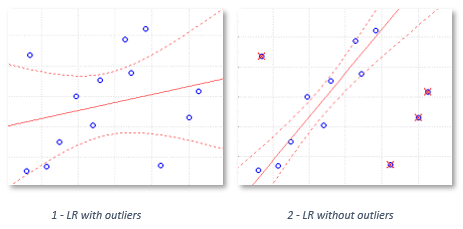

In [49]:
Image("img/outliers.png")

Because of that, we need to remove or replace outliers. We will try both of those methods - dropping rows with outliers and also replacing outliers with 5% and 95% quantile. After doing so, we will compare both of them.

In [50]:
class OutliersRemover(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.Q1 = {}
        self.Q3 = {}

    def fit(self, df, y=None, **fit_params):
        for column in self.columns:
            self.Q1[column] = df[column].quantile(.25)
            self.Q3[column] = df[column].quantile(.75)
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            Q1 = self.Q1[column]
            Q3 = self.Q3[column]
            lower_outlier = Q1 - (Q3 - Q1) * 1.5
            upper_outlier = Q3 + (Q3 - Q1) * 1.5

            df_copy = df_copy[(df_copy[column] >= lower_outlier) & (df_copy[column] <= upper_outlier)]
        return df_copy


class OutliersReplacer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.Q1 = {}
        self.Q3 = {}
        self.quantile_95 = {}
        self.quantile_05 = {}

    def replace_outlier(self, x, column):
        Q1 = self.Q1[column]
        Q3 = self.Q3[column]
        lower_outlier = Q1 - (Q3 - Q1) * 1.5
        upper_outlier = Q3 + (Q3 - Q1) * 1.5

        if x < lower_outlier:
            return self.quantile_05[column]
        elif x > upper_outlier:
            return self.quantile_95[column]
        else:
            return x

    def fit(self, df, y=None, **fit_params):
        for column in self.columns:
            self.Q1[column] = df[column].quantile(.25)
            self.Q3[column] = df[column].quantile(.75)
            self.quantile_95[column] = df[column].quantile(.95)
            self.quantile_05[column] = df[column].quantile(.05)
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy[column] = df_copy[column].apply(lambda x: self.replace_outlier(x, column))
            
        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Normalize attributes and remove outliers using Pipeline

At first, we need to normalize data. After that, we will proceed removing outliers and replacing outliers separately (for easy comparison later). For this preprocessing, we have chosen only attributes with hormones (**T4U**, **T3**, **TSH**, **TT4**, **FTI**), **education-num**, **fnlwgt** and **age** for visualization of preprocessing. If needed, other attributes can be preprocessed in future easily with prepared pipelines.


As expected, those changes will be done using Pipeline:

In [51]:
# data normalization
normalize_ppl = Pipeline([
                ('norm_numerical', Normalizer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num', 'fnlwgt']))
              ])

# removing outliers
outliers_ppl = Pipeline([
                ('rmout_numerical', OutliersRemover(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num', 'fnlwgt']))
              ])

# replacing outliers
outliers_repl_ppl = Pipeline([
                        ('reout_numerical', OutliersReplacer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num', 'fnlwgt']))
                    ])

In [52]:
only_normalized = normalize_ppl.fit_transform(repaired)
normalized_replaced = outliers_repl_ppl.fit_transform(only_normalized)
normalized_removed = outliers_ppl.fit_transform(only_normalized)

#### Data normalization overview

Graphical overview of the executed changes in the selected columns - **before normalization**, **after normalization**, **after removing outliers** and **after replacing outliers**:
- **after normalization**:
    - we can notice that in some cases the peak of the graph has been moved to *zero*
    - x-axis scale range has been changed due to logarithm
    - outliers may still persist
- **the outliers fix**:
    - both outliers removal and replacing have noticably changed the distribution
        - in both cases the x-axis scales have been changed
    - Replacing:
        - instead of removing the outliers, algorithm replaced these outlaying values either by 0.95 or 0.05 quantile, therefore some values may have a higher frequency after the process
        
**Note:** All graphical overviews are listed below.

##### T4U

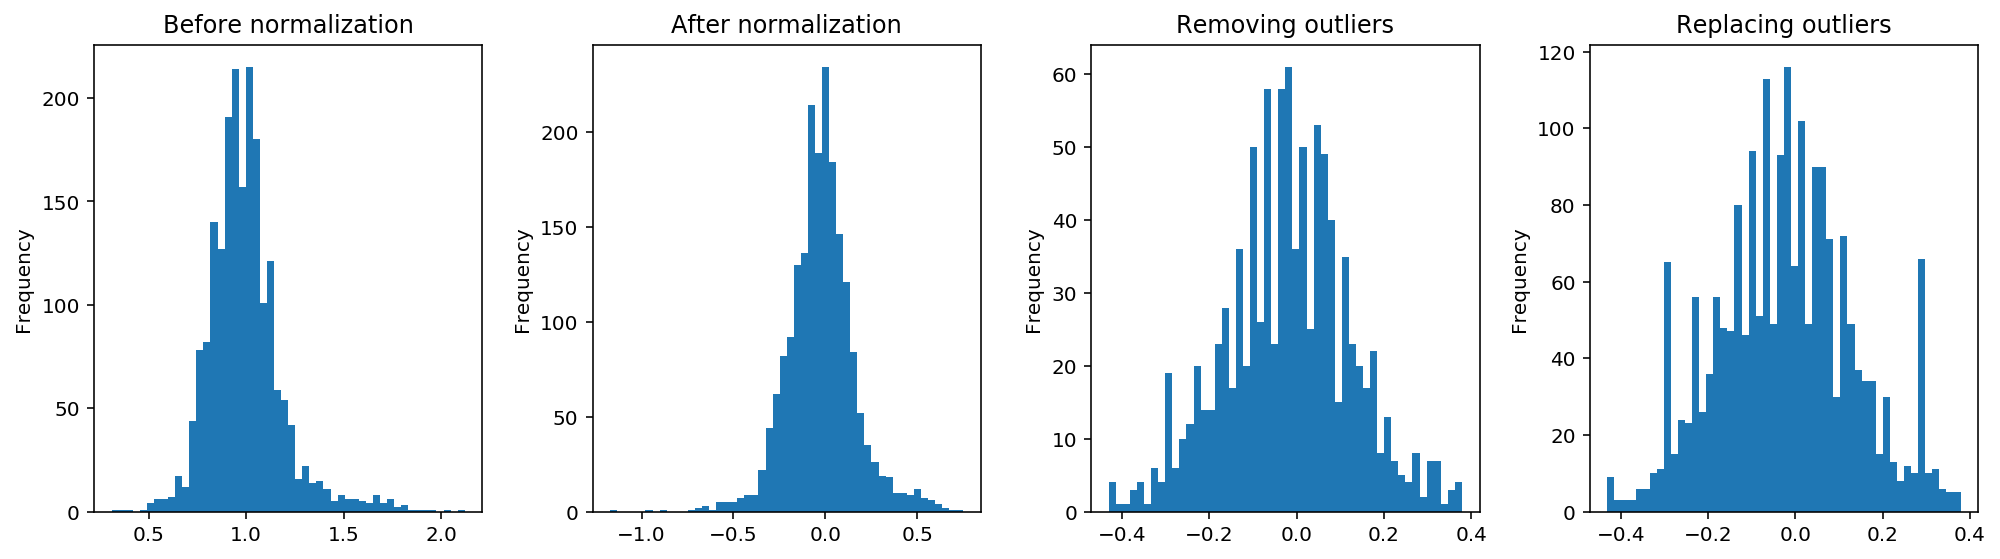

In [53]:
data_normalization_compare(repaired['T4U'], only_normalized['T4U'], normalized_removed['T4U'], normalized_replaced['T4U'])

##### TSH

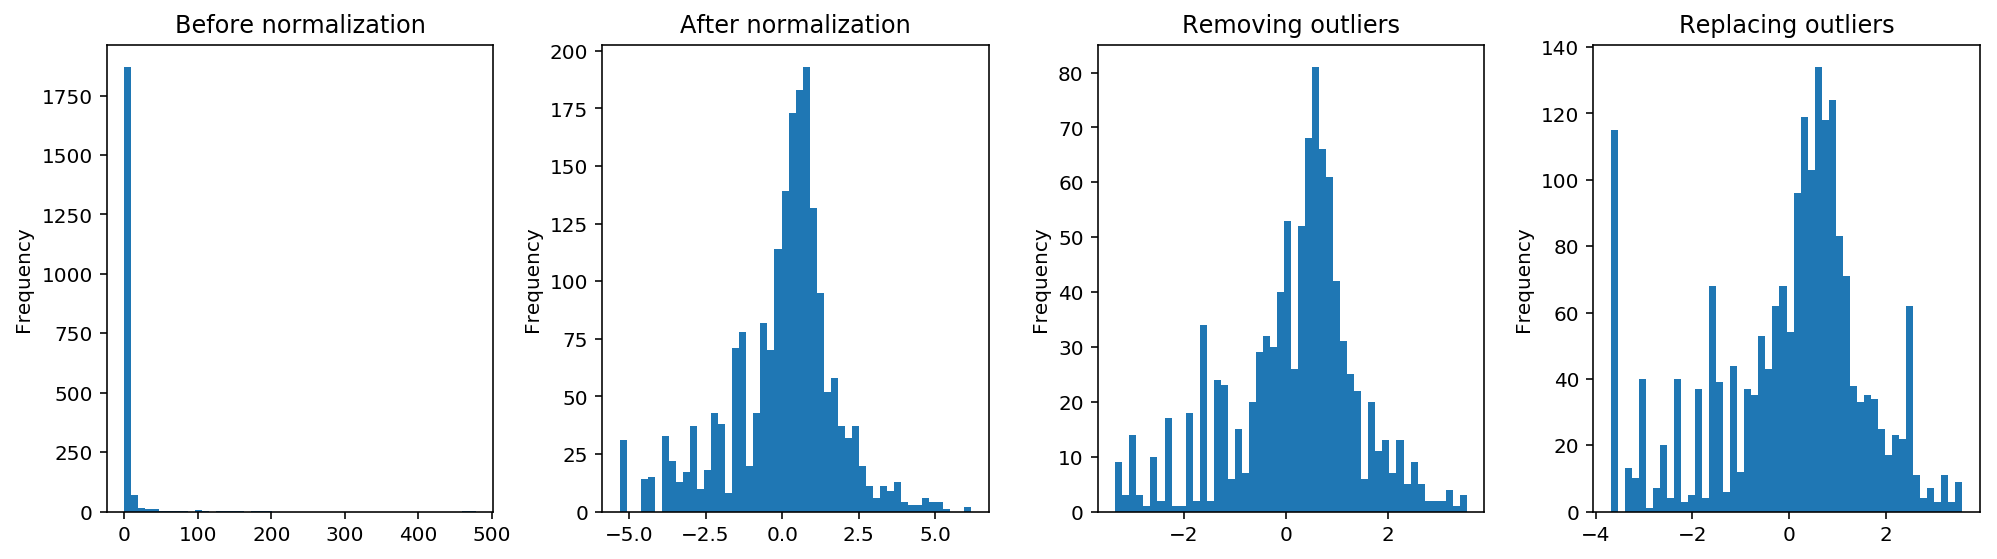

In [54]:
data_normalization_compare(repaired['TSH'], only_normalized['TSH'], normalized_removed['TSH'], normalized_replaced['TSH'])

##### T3

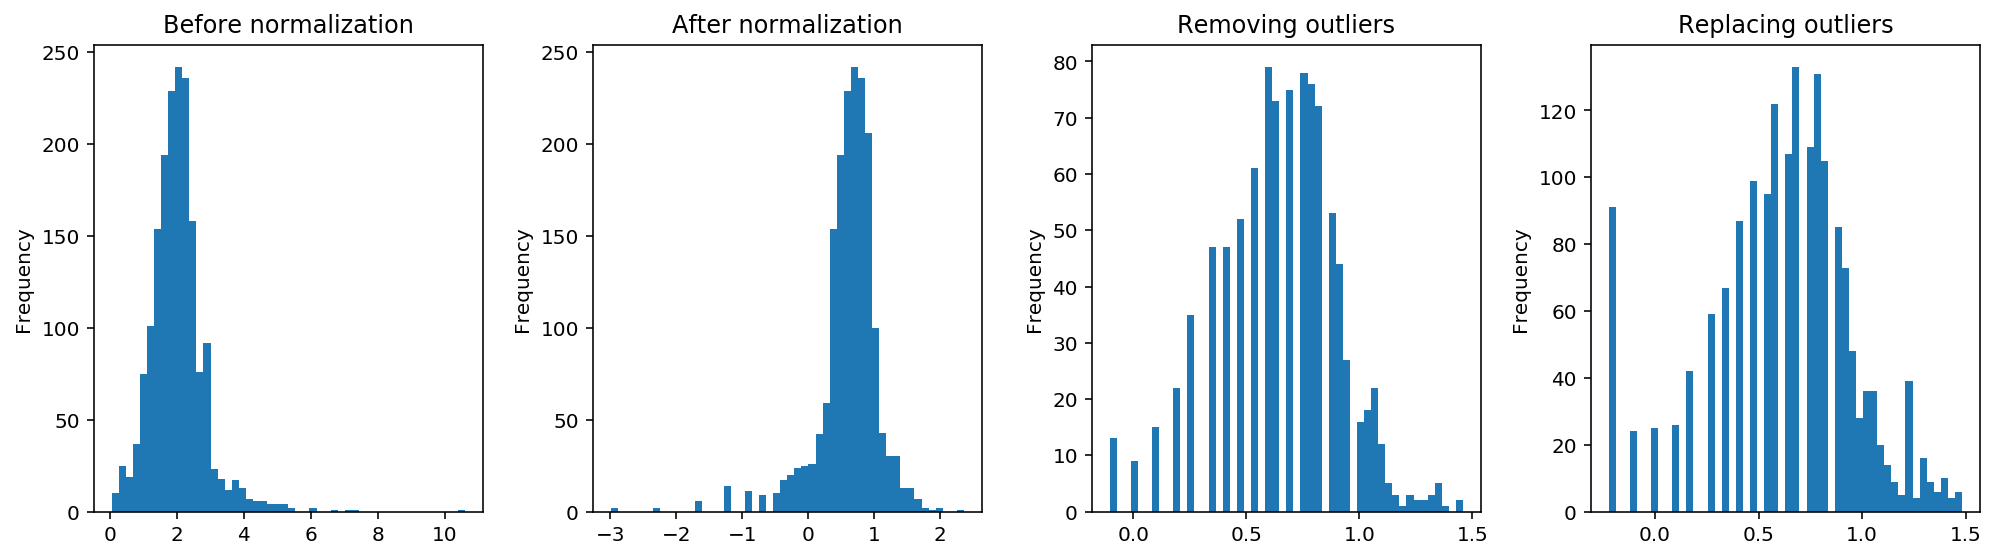

In [55]:
data_normalization_compare(repaired['T3'], only_normalized['T3'], normalized_removed['T3'], normalized_replaced['T3'])

##### TT4

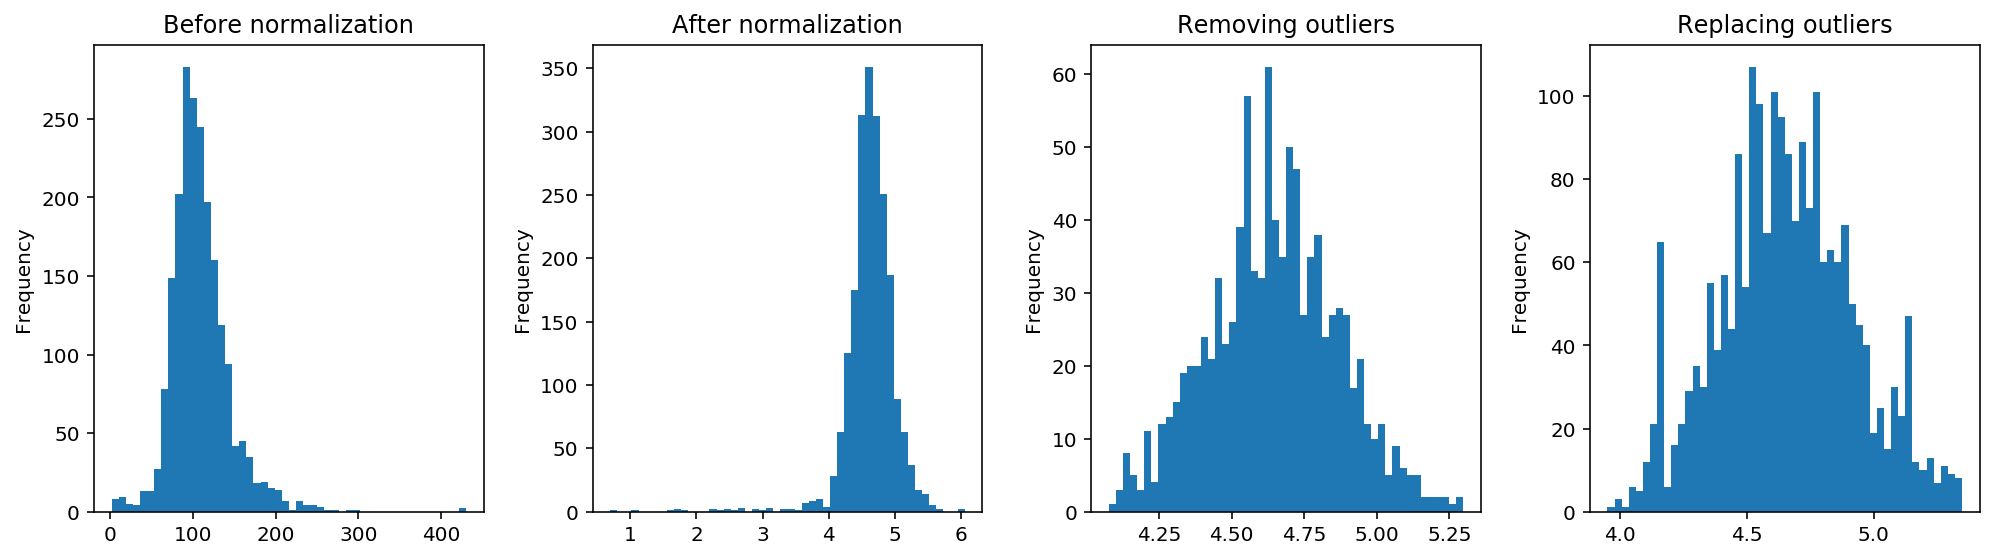

In [56]:
data_normalization_compare(repaired['TT4'], only_normalized['TT4'], normalized_removed['TT4'], normalized_replaced['TT4'])

##### FTI

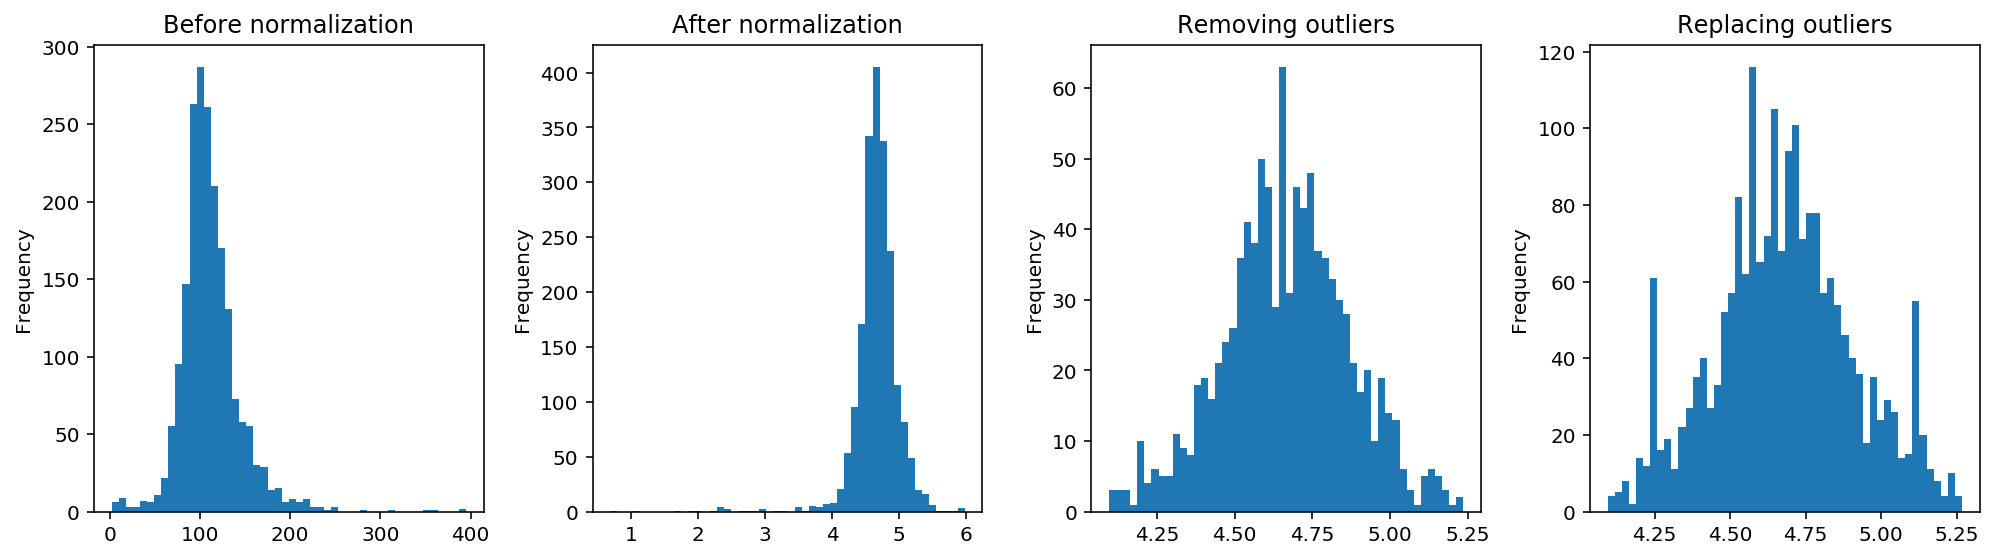

In [57]:
data_normalization_compare(repaired['FTI'], only_normalized['FTI'], normalized_removed['FTI'], normalized_replaced['FTI'])

##### age

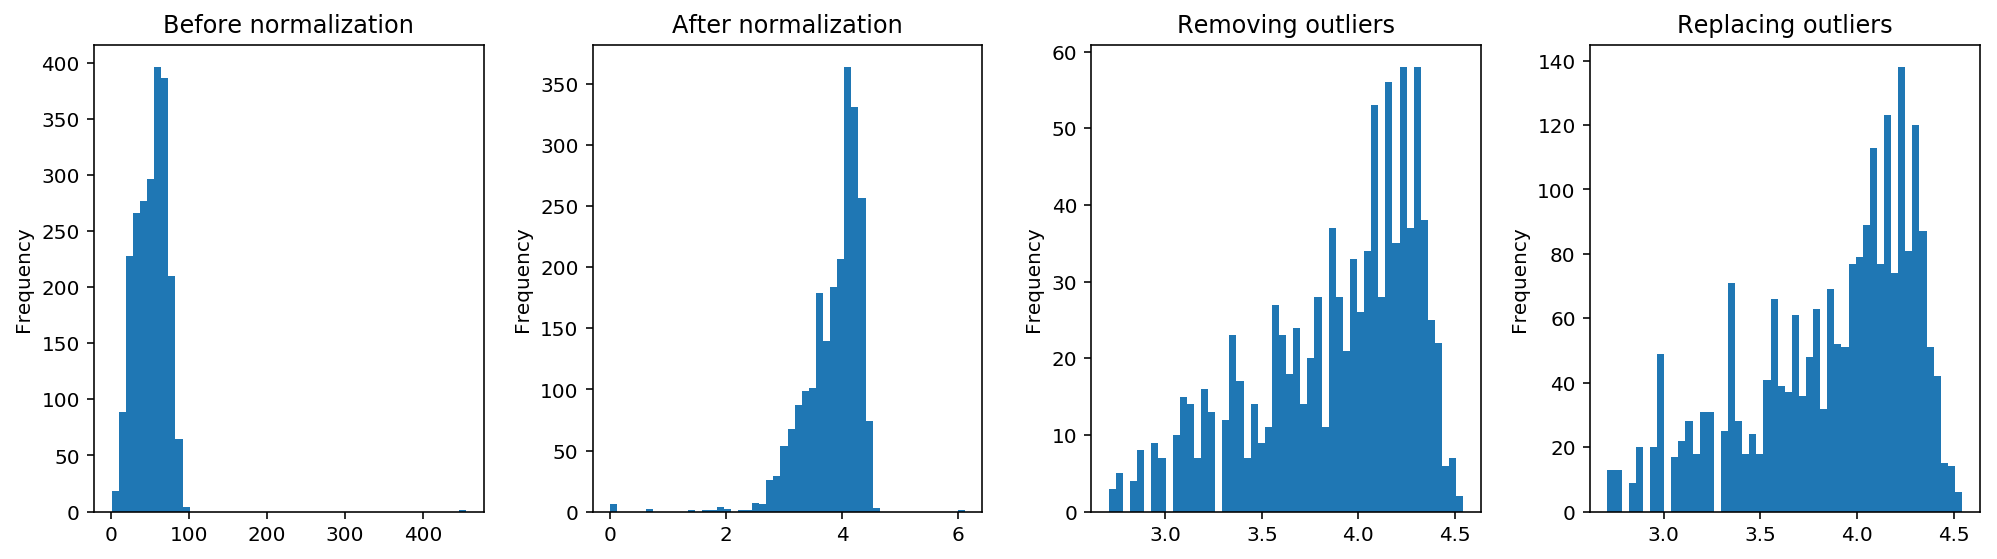

In [58]:
data_normalization_compare(repaired['age'], only_normalized['age'], normalized_removed['age'], normalized_replaced['age'])

##### education-num

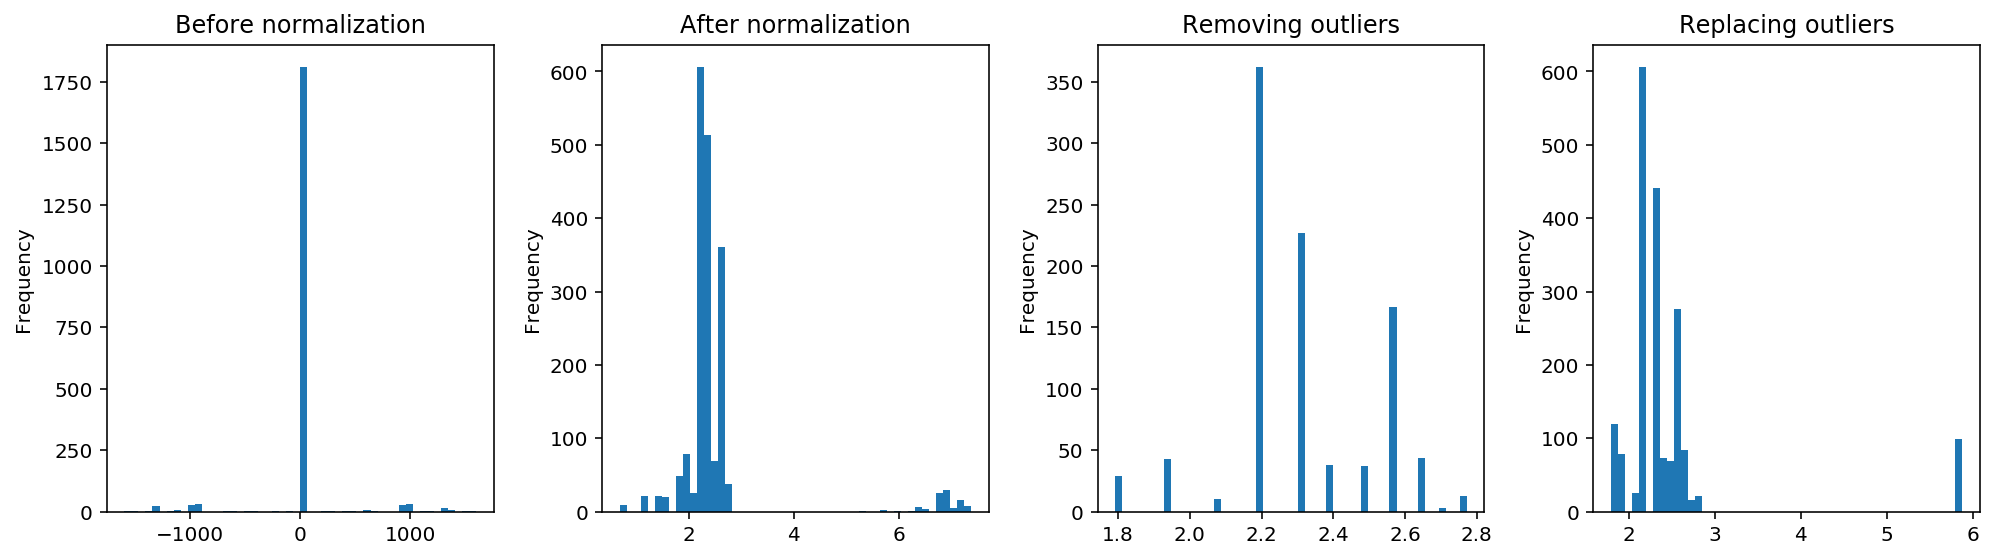

In [59]:
data_normalization_compare(repaired['education-num'], only_normalized['education-num'], normalized_removed['education-num'], normalized_replaced['education-num'])

##### fnlwgt

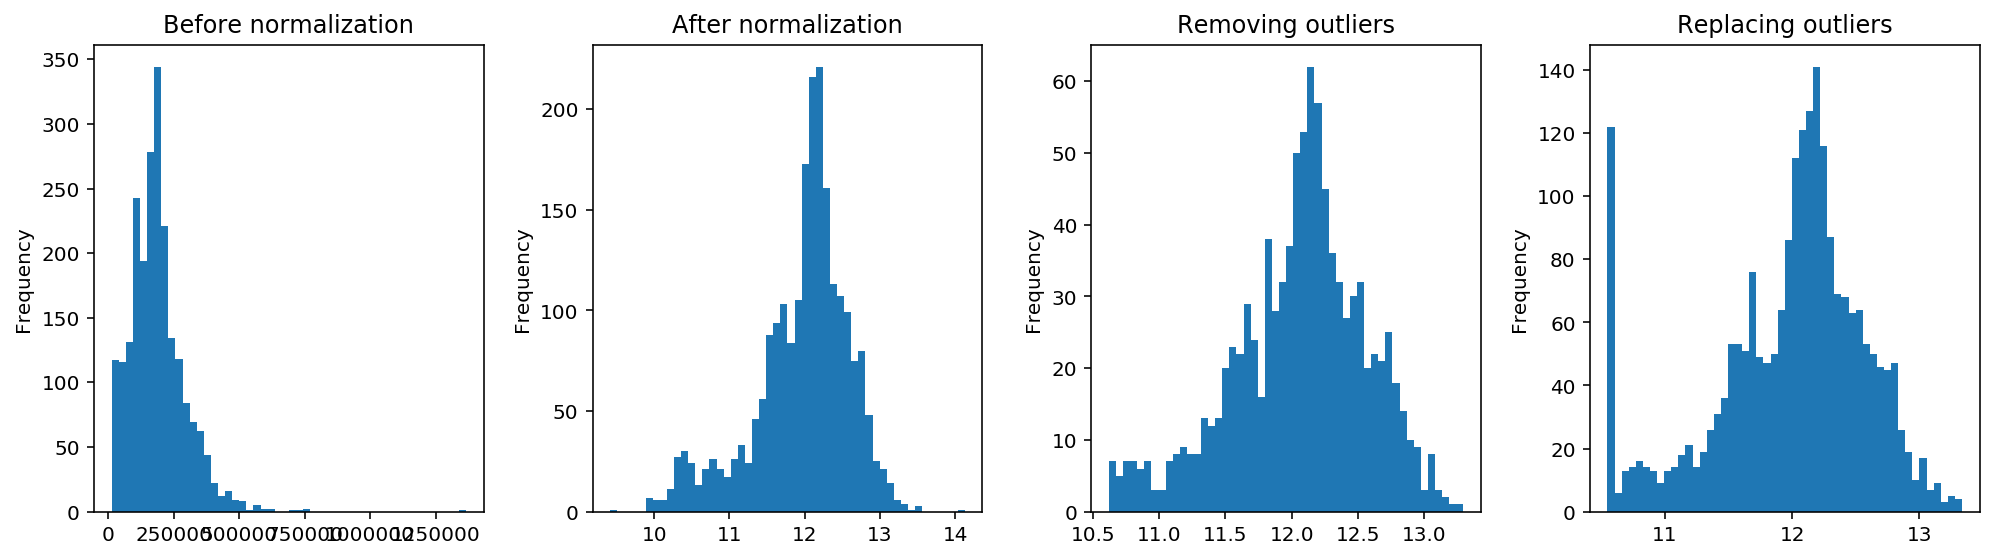

In [60]:
data_normalization_compare(repaired['fnlwgt'], only_normalized['fnlwgt'], normalized_removed['fnlwgt'], normalized_replaced['fnlwgt'])

As suggested before, outliers may persist after normalization. On the graphs below, we can see comparison of column values distribution from the outliers point of view. The graphs show the state **after normalization** and **after processing of outliers removal and outliers replacing** over normalized columns (each in a separate graph). Even though the outliers removal and replacement have been executed, some outliers still remain according to boxplots. As in most cases, they are near border points, they may not necessarily influence model.

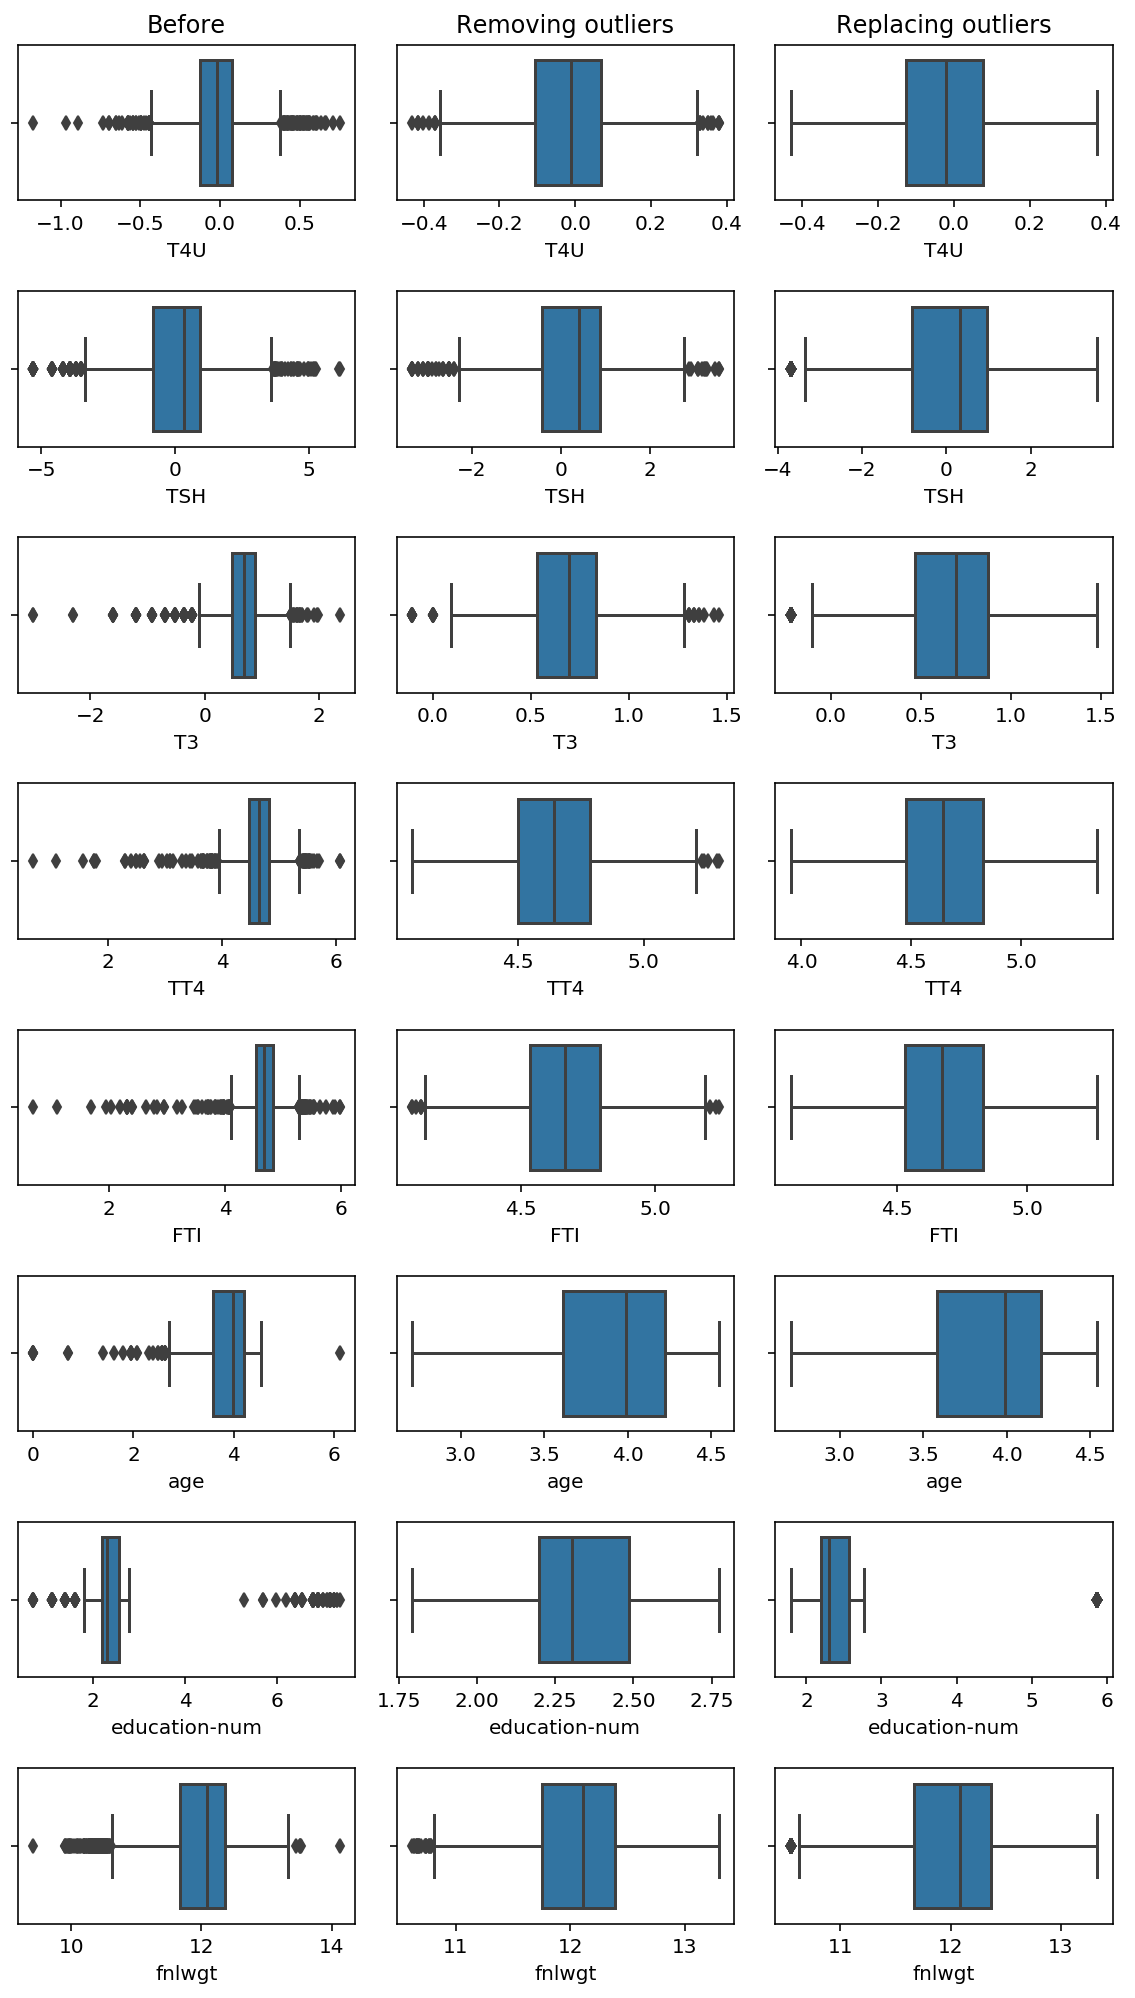

In [61]:
compare_outliers(only_normalized, normalized_removed, normalized_replaced, ['T4U', 'TSH', 'T3', 'TT4', 'FTI', 'age', 'education-num', 'fnlwgt'])

As mentioned before, when outliers are detected, we should figure them out. There are two main approaches to handle outliers - **removing** them or **replacing** them with another value. Both approaches have pros and cons.

Replacing outliers with 0.95 and 0.05 quantiles would probably change distribution of values, but keep all the data so we do not have to think about loosing important information from other attributes.

Removing outliers is the easy way, without changing distribution of values. On the other hand, removing outliers can cause loss of important information stored in removed rows. From our point of view, we think it is better to replace them rather than remove.

### Filling missing values

Our dataset also contains missing values (NaN), that should be filled before using any machine learning algorithm. Missing values of numerical, and also categorical attributes should be filled. For both types of attributes, two approaches will be tried.

For numerical attributes, we will fill missing values with **median** and also predict values using **linear regression model**. After doing so, both methods will be compared.

For categorical attributes, missing values will be filled by **most frequent** value, and as in numerical attributes, we will also predict category using **k-nearest neighbours model**. Then we will compare the results.

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection as ms
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#### Fill numerical with median

Numerical attributes can be filled by median, stdev, etc. For this purposes, we have chosen *median*.

Initially, we wanted to use *SimpleImputer* in combination with *FeatureUnion* and *FunctionTransformer*, to choose numerical and categorical attributes. There is a problem using that, because *FeatureUnion* and *FunctionTransformer* create *numpy* arrays from our DataFrame. There could be one more transformation to dataframe, but we decided to create our own, more simple solution.

In [63]:
class NumMedianFiller(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.medians = {}
        
    def fit(self, df, y=None, **fit_params):
        for column in self.columns:
            self.medians[column] = df[column].median()
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy[column] = df[column].apply(lambda x: self.medians[column] if pd.isna(x) else x)
        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Fill numerical with Linear Regression algorithm

Another approach to be compared with previously mentioned median method, is to fill missing values by predicting them using *Linear Regression* algorithm. In pipeline, linear regression model is trained. Also cross-validation is used to know how good our model performs.

In [64]:
class NumModelFiller(TransformerMixin):
    def __init__(self, column, model):
        self.column = column
        self.model = model
        self.medians = {}

    def fit(self, df, y=None, **fit_params):
        # choose all numeric attributes and drop nan values
        num_only = df.select_dtypes(include=[np.number]).dropna()

        # create X and y training subsets
        X_train = num_only[num_only.columns.difference([self.column])]
        y_train = num_only[self.column]

        self.columns = X_train.columns.values
        for column in self.columns:
            self.medians[column] = X_train[column].median()

        scores = cross_val_score(self.model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
        print("Score for column " + self.column + ": " + str(scores.mean()))

        self.model.fit(X_train, y_train)
        
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        if df[self.column].isnull().any():
            # choose only those rows that have missing value in 'column' attribute
            empty_rows = df_copy[df_copy[self.column].isnull()][self.columns]

            for column in self.columns:
                empty_rows.loc[empty_rows[column].isnull(), column] = self.medians[column]
            
            # create X subset, that will predict
            X_pred = empty_rows[empty_rows.columns.difference([self.column])]

            # predict new values
            y_pred = self.model.predict(X_pred)

            # fill missing values with predicted ones
            df_copy.loc[empty_rows.index, self.column] = y_pred

        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Fill numerical attributes using Pipeline

After creating pipelines for filling missing values of numerical attributes, we will perform transformation using pipeline. Let's check numerical attributes to decide, missing values of which columns should be filled:

In [65]:
normalized_replaced.select_dtypes(include=[np.number]).isnull().sum()

index               0
age                 1
TT4               148
T4U               235
capital-loss        0
capital-gain        0
TSH               232
T3                467
fnlwgt              0
FTI               233
hours-per-week      0
education-num     328
dtype: int64

As we can see, only columns storing hormones measurements, fnlwgt, age and education-num contain missing values. **For preprocessing visualization, we will fill in only the mentioned columns containing missing values. However, we will fill in all the numerical columns in the final pipeline as we don't know which columns have missing values in valid dataset.**

In [66]:
lr = LinearRegression()
fill_lr_ppl = Pipeline([
                ('flr_T4U', NumModelFiller('T4U', lr)),
                ('flr_TT4', NumModelFiller('TT4', lr)),
                ('flr_T3', NumModelFiller('T3', lr)),
                ('flr_TSH', NumModelFiller('TSH', lr)),
                ('flr_FTI', NumModelFiller('FTI', lr)),
                ('flr_age', NumModelFiller('age', lr)),
                ('flr_education_num', NumModelFiller('education-num', lr)),
                ('flr_fnlwgt', NumModelFiller('fnlwgt', lr))
            ])
fill_median_ppl = Pipeline([
                        ('median_filling', NumMedianFiller(['T4U', 'TT4', 'T3', 'TSH', 'FTI', 'age', 'education-num','fnlwgt']))
                    ])

Below we can see *mean squared* errors of classificator's predictions for each of the columns. The score is gained using cross validation.

In [67]:
# Missing values filled using Linear Regression
filled_model = fill_lr_ppl.fit_transform(normalized_replaced)

Score for column T4U: -0.003748839734483902


Score for column TT4: -0.004458008578995587


Score for column T3: -0.07916645275022151


Score for column TSH: -1.8750001419108895


Score for column FTI: -0.0037931236346083795


Score for column age: -0.16690350447517294


Score for column education-num: -0.6847698752538791


Score for column fnlwgt: -0.36569098838391173


In [68]:
# Missing values filled using median
filled_median = fill_median_ppl.fit_transform(normalized_replaced)

#### Compare filling methods using median and model

After filling missing numerical values with median and linear regression model, we have to compare both approaches. In case of median replacement, we can watch that only median frequency was elevated. Using model, missing values were predicted throughout the distribution.

To see concrete changes of distribution **before filling**, **after filling using median** and **after filling using model**, see plots below.

##### T4U

Median frequency was elevated highly after filling. This is because a lot of values had to be filled. Model dealt better:

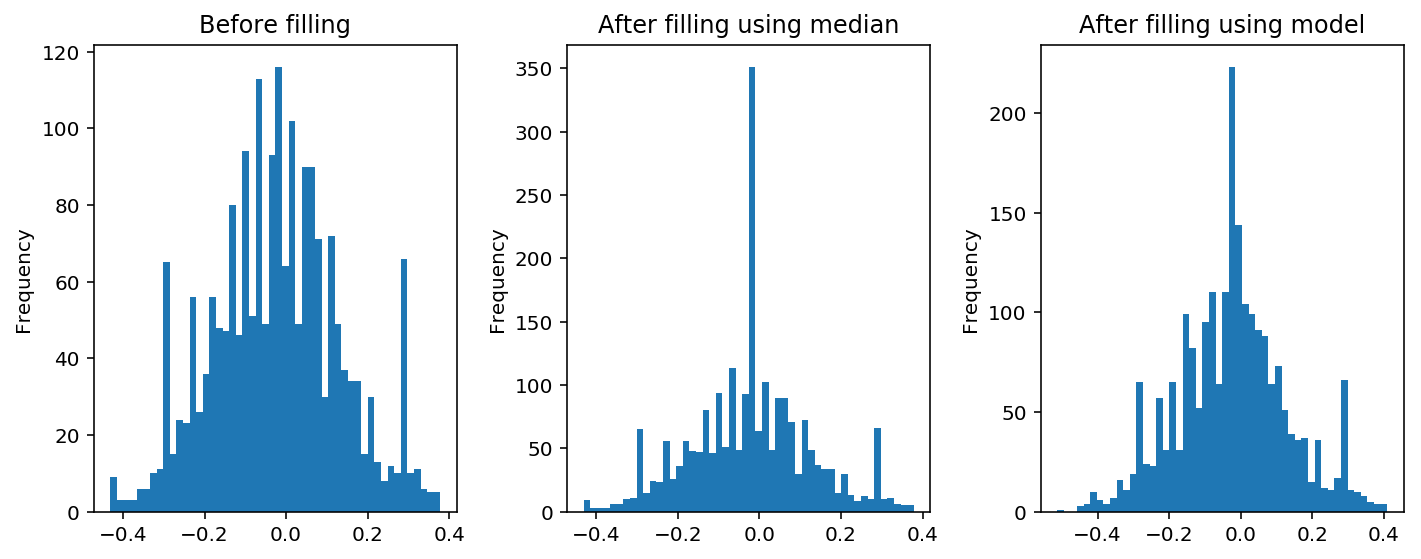

In [69]:
compare_filling(normalized_replaced['T4U'], filled_median['T4U'], filled_model['T4U'])

##### TT4

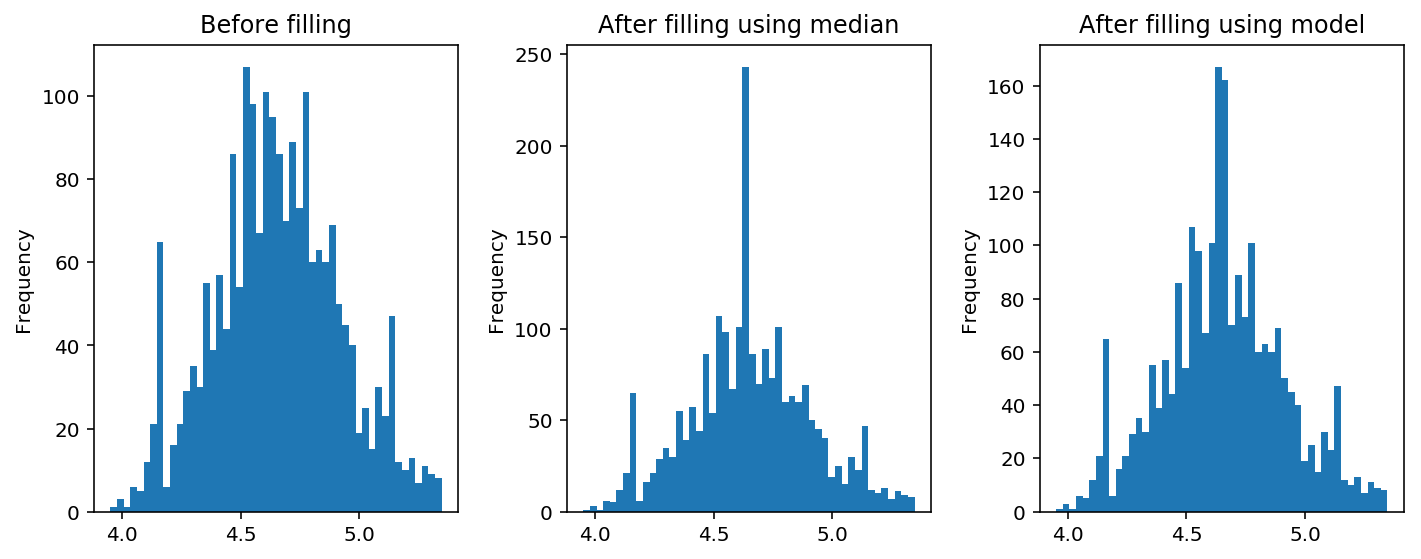

In [70]:
compare_filling(normalized_replaced['TT4'], filled_median['TT4'], filled_model['TT4'])

##### TSH

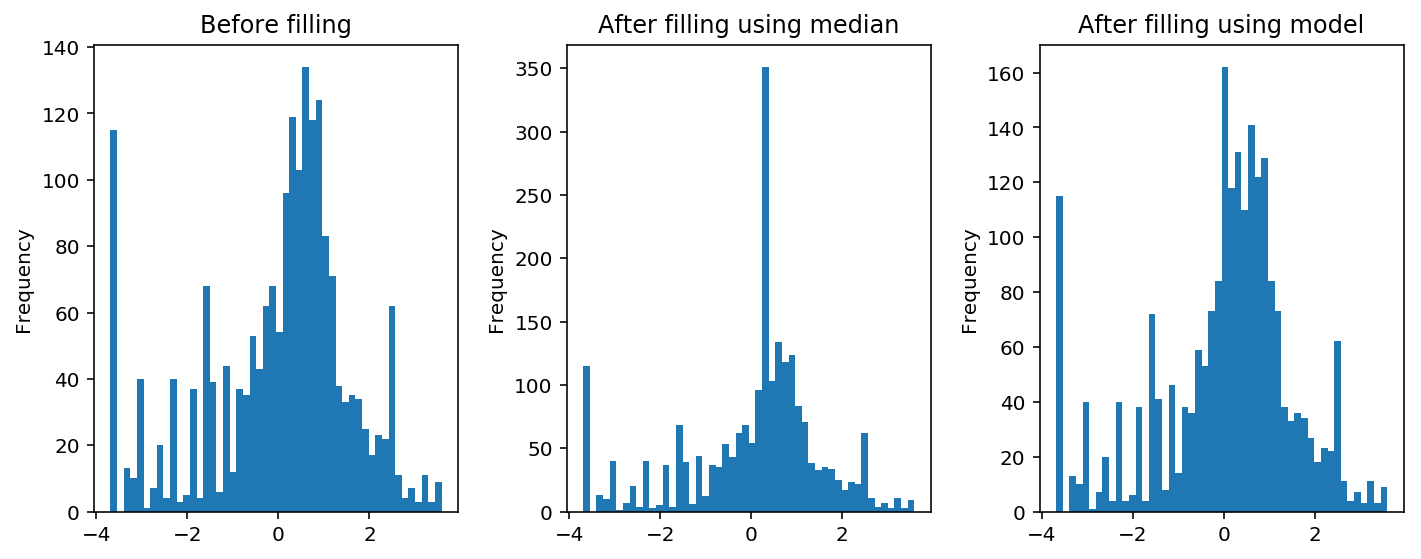

In [71]:
compare_filling(normalized_replaced['TSH'], filled_median['TSH'], filled_model['TSH'])

##### T3

In case of value **T3**, it looks like lot of values needed to be filled. Because of that, in median column we can see very high frequency of median value after using it. In case of filling missing values with model, it looks really better, so predicted values were from whole distribution, depending on input values.

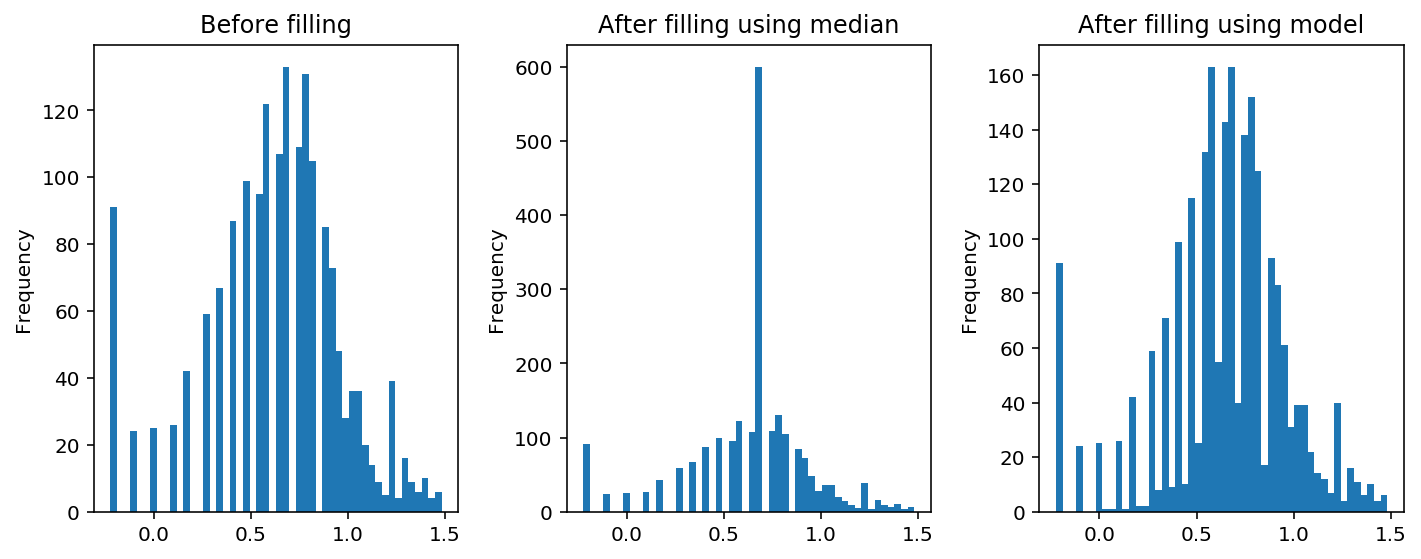

In [72]:
compare_filling(normalized_replaced['T3'], filled_median['T3'], filled_model['T3'])

##### FTI

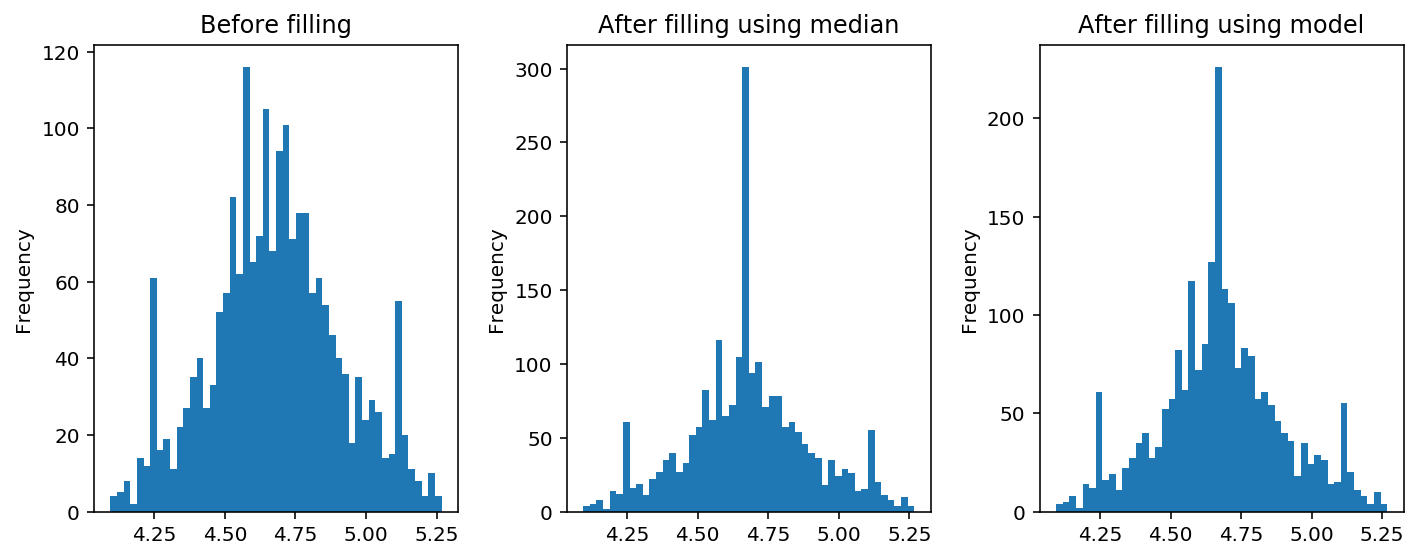

In [73]:
compare_filling(normalized_replaced['FTI'], filled_median['FTI'], filled_model['FTI'])

##### age

In age attribute, only one value had to be filled, so no significant difference can be spoted.

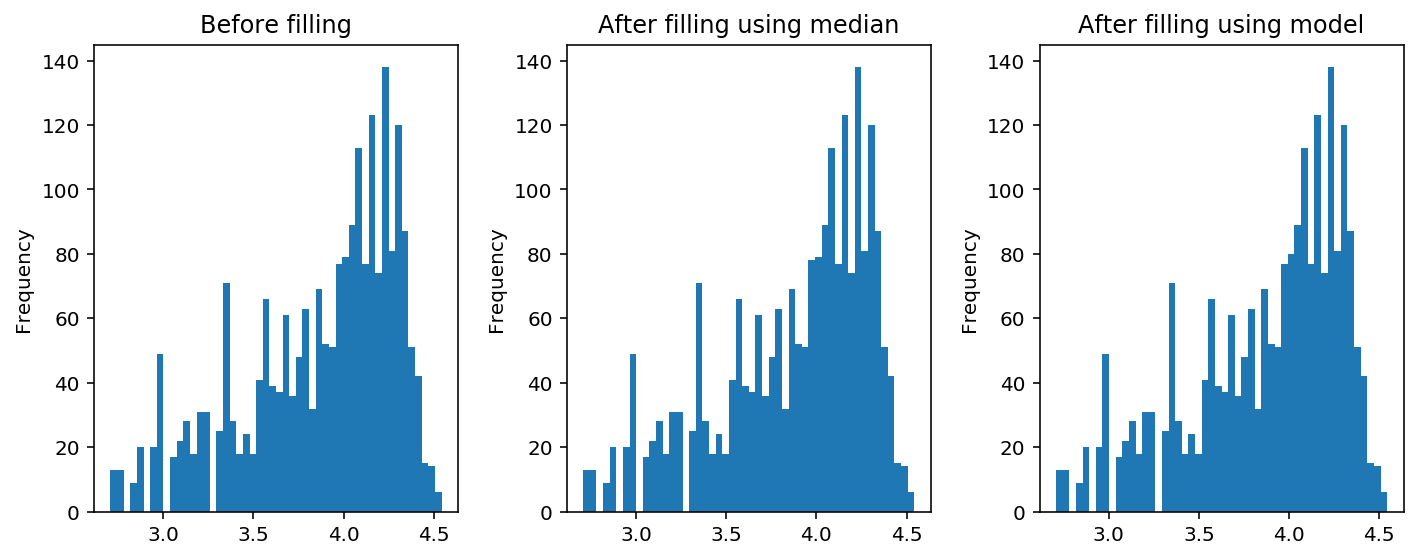

In [74]:
compare_filling(normalized_replaced['age'], filled_median['age'], filled_model['age'])

##### education-num

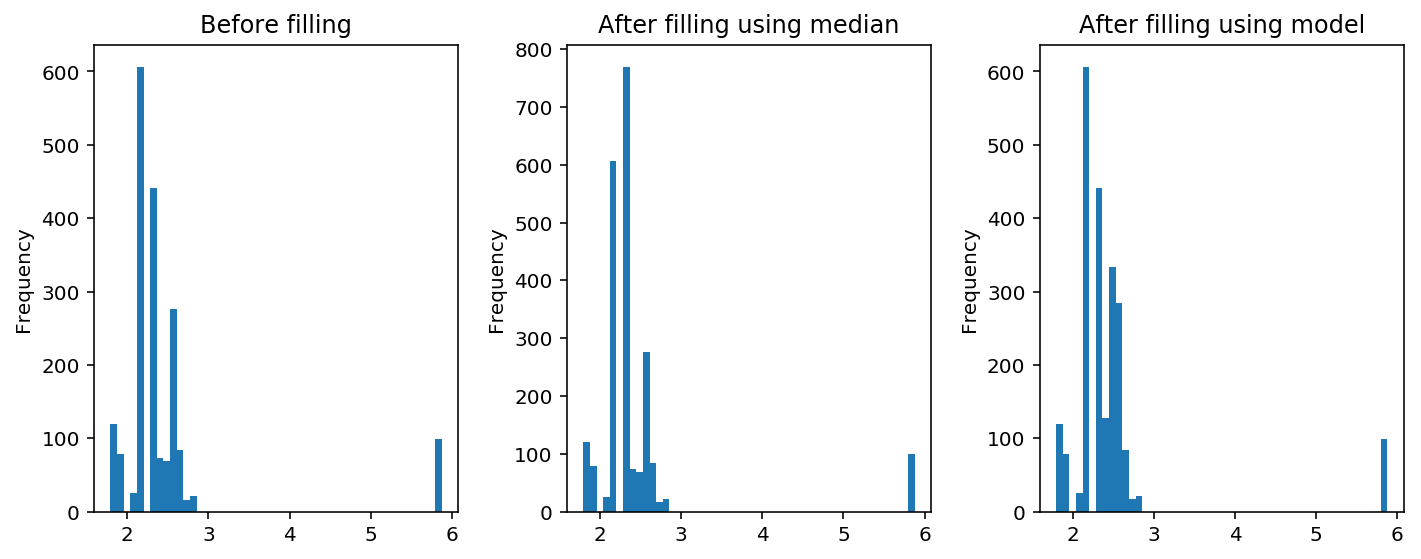

In [75]:
compare_filling(normalized_replaced['education-num'], filled_median['education-num'], filled_model['education-num'])

##### fnlwgt

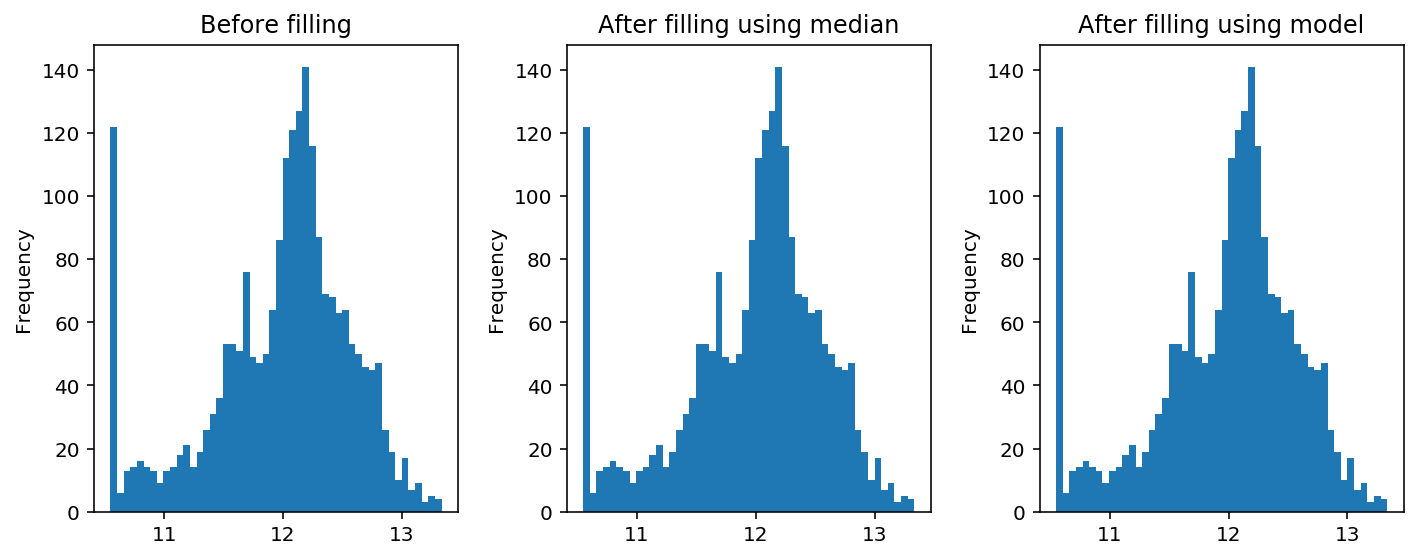

In [76]:
compare_filling(normalized_replaced['fnlwgt'], filled_median['fnlwgt'], filled_model['fnlwgt'])

**From our point of view, it is better to use filling values using model rather than filling them by median. *T3* hormone is perfect example of how filling values with model can perform better and does not change the distribution overly.**

#### Fill categorical with most frequent values

Categorical attributes can be filled by *most frequent* value which we have chosen for this purpose.
The reason for preferring our own way of filling values to imputer is already mentioned above.

In [77]:
class CategoricalMostFrequentFiller(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.most_frequents = {}
        
    def fit(self, df, y=None, **fit_params):
        for column in self.columns:
            self.most_frequents[column] = str(df[column].mode()[0])
        return self
    
    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            if (type(df_copy[column].values[0]) == bool):
                self.most_frequents[column] = bool(self.most_frequents[column])
            df_copy.loc[df_copy[column].isnull(), column] = self.most_frequents[column]
        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Fill categorical with RandomForest algorithm

Another approach to be compared to most frequent method, is to fill missing values using classifier - RandomForest to predict the values to be filled.

In [78]:
# necessary imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

pd.options.mode.chained_assignment = None  # default='warn'

Class handling the training and prediction process:

In [79]:
class CategoricalModelFiller(TransformerMixin):
    def __init__(self, column, model):
        self.column = column
        self.model = model
        self.most_frequents = {}

    def fit(self, df, y=None, **fit_params):

        # choose all numeric attributes and drop nan values
        num_only = df.select_dtypes(include=[np.number])

        num_only[self.column] = df[self.column]

        num_only = num_only.dropna()

        # create X and y training subsets
        X_train = num_only[num_only.columns.difference([self.column])]
        y_train = num_only[self.column].astype(str)

        self.columns = X_train.columns.values
        for column in self.columns:
            self.most_frequents[column] = str(X_train[column].mode()[0])

        scores = cross_val_score(self.model, X_train, y_train, scoring="accuracy", cv=10)
        print("Score for column " + self.column + ": " + str(scores.mean()))

        self.model.fit(X_train, y_train)
        
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        if df[self.column].isnull().any():
            # choose only those rows that have missing value in 'column' attribute
            empty_rows = df_copy[df_copy[self.column].isnull()][self.columns]

            for column in self.columns:
                empty_rows.loc[empty_rows[column].isnull(), column] = self.most_frequents[column]

            # create X subset, that will predict
            X_pred = empty_rows

            # predict new values
            y_pred = self.model.predict(X_pred)

            # fill missing values with predicted ones
            if (type(df_copy[self.column].values[0]) == bool):
                y_pred = y_pred.astype(bool)
            df_copy.loc[empty_rows.index, self.column] = y_pred

        return df_copy

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Fill categorical attributes using Pipeline

Missing values of categorical attributes will be filled using both most frequent values and with predictions using model. For every prediction, score will be displayed. The score is gained using cross validation.

In [80]:
normalized_replaced.select_dtypes(exclude=[np.number]).isnull().sum()

name                           0
address                        0
sex                           88
date_of_birth                  1
query hyperthyroid             0
T4U measured                   0
FTI measured                   0
lithium                        0
query hypothyroid              0
on thyroxine                   0
tumor                          0
sick                           0
thyroid surgery                0
workclass                      0
I131 treatment                 0
TT4 measured                   0
class                          0
goitre                         0
TSH measured                   0
hypopituitary                  0
query on thyroxine             0
personal_info                  0
T3 measured                    0
on antithyroid medication      0
referral source                0
psych                          0
occupation                   156
pregnant                     152
class_status                   0
bred                           0
origin    

As we can see, there are several categorical columns with missing values. Filling using model will be done just with 4 attributes - **sex**, **pregnant**, **origin** and **occupation**. *date_of_birth* attribute contains also one missing value, but also contains a lot of unique values, so it is better to fill this missing value just with most frequent method. **For preprocessing visualization, we will fill in only the mentioned columns containing missing values. However, we will fill in all the categorical columns in the final pipeline as we don't know which columns have missing values in valid dataset.**

For filling values using model, we have chosen RandomForest as it performs significantly better than KNN algorithm. Despite our choice, our pipeline for filling missing values of categorical attributes is universal so any classification model can be passed as argument.

In [81]:
fill_mf_ppl = Pipeline([
                ('fill_mf', CategoricalMostFrequentFiller(['pregnant', 'sex', 'occupation', 'origin', 'date_of_birth']))
            ])

rf = RandomForestClassifier(n_estimators=100, max_depth=7)
fill_rf_ppl = Pipeline([
                    ('fill_rf_sex', CategoricalModelFiller('sex', rf)),
                    ('fill_rf_pregnant', CategoricalModelFiller('pregnant', rf)),
                    ('fill_rf_occupation', CategoricalModelFiller('occupation', rf)),
                    ('fill_rf_origin', CategoricalModelFiller('origin', rf))
                ])

In [82]:
filled_most_frequent = fill_mf_ppl.fit_transform(filled_model)
filled_rf = fill_rf_ppl.fit_transform(filled_model)

Score for column sex: 0.7166017653167185


Score for column pregnant: 0.9865705328233932


Score for column occupation: 0.2828737986149705


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Score for column origin: 0.8824561638073453


#### Compare filling methods using most frequent value and model
Comparison of values distribution - before filling values, after filling by most frequent and filling using Random Forest.

##### sex

Let's take a look at how distribution of values for attribute *sex* gets affected by filling (88 missing values):
- before filling: we can see there were some NaN values
- most frequent and model method: we can't notice any major difference looking at the graphs side by side

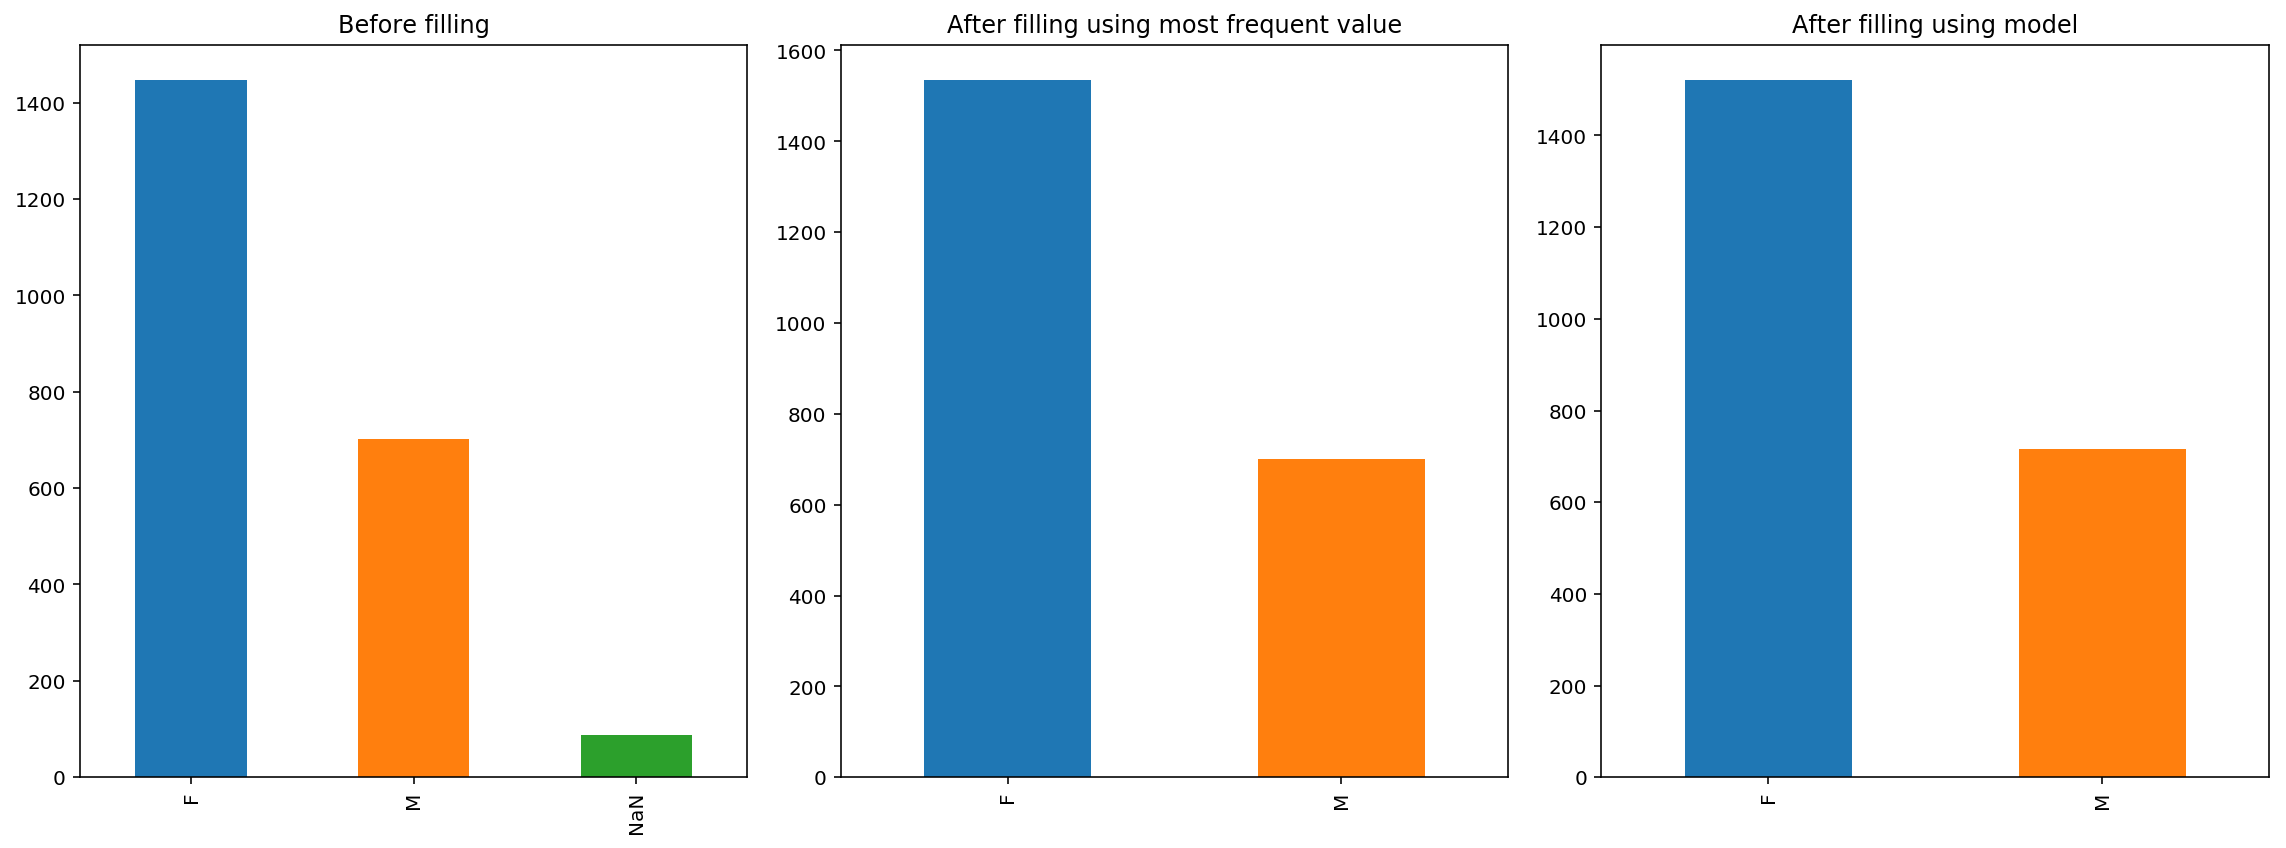

In [83]:
compare_distributions(filled_model['sex'], filled_most_frequent['sex'], filled_rf['sex'])

##### occupation

Let's take a look at how distribution of values for attribute *occupation* gets affected by filling (**?** missing values):
- **before filling**: 
    - we can see there was a noticable portion of NaN values
- **most frequent method**:
    - we can see that the value which was previously the most frequent gained even higher advantage (as expected)
- **model method**:
    - we can see that not just the previously most frequent value gained advantage, but the others did as well

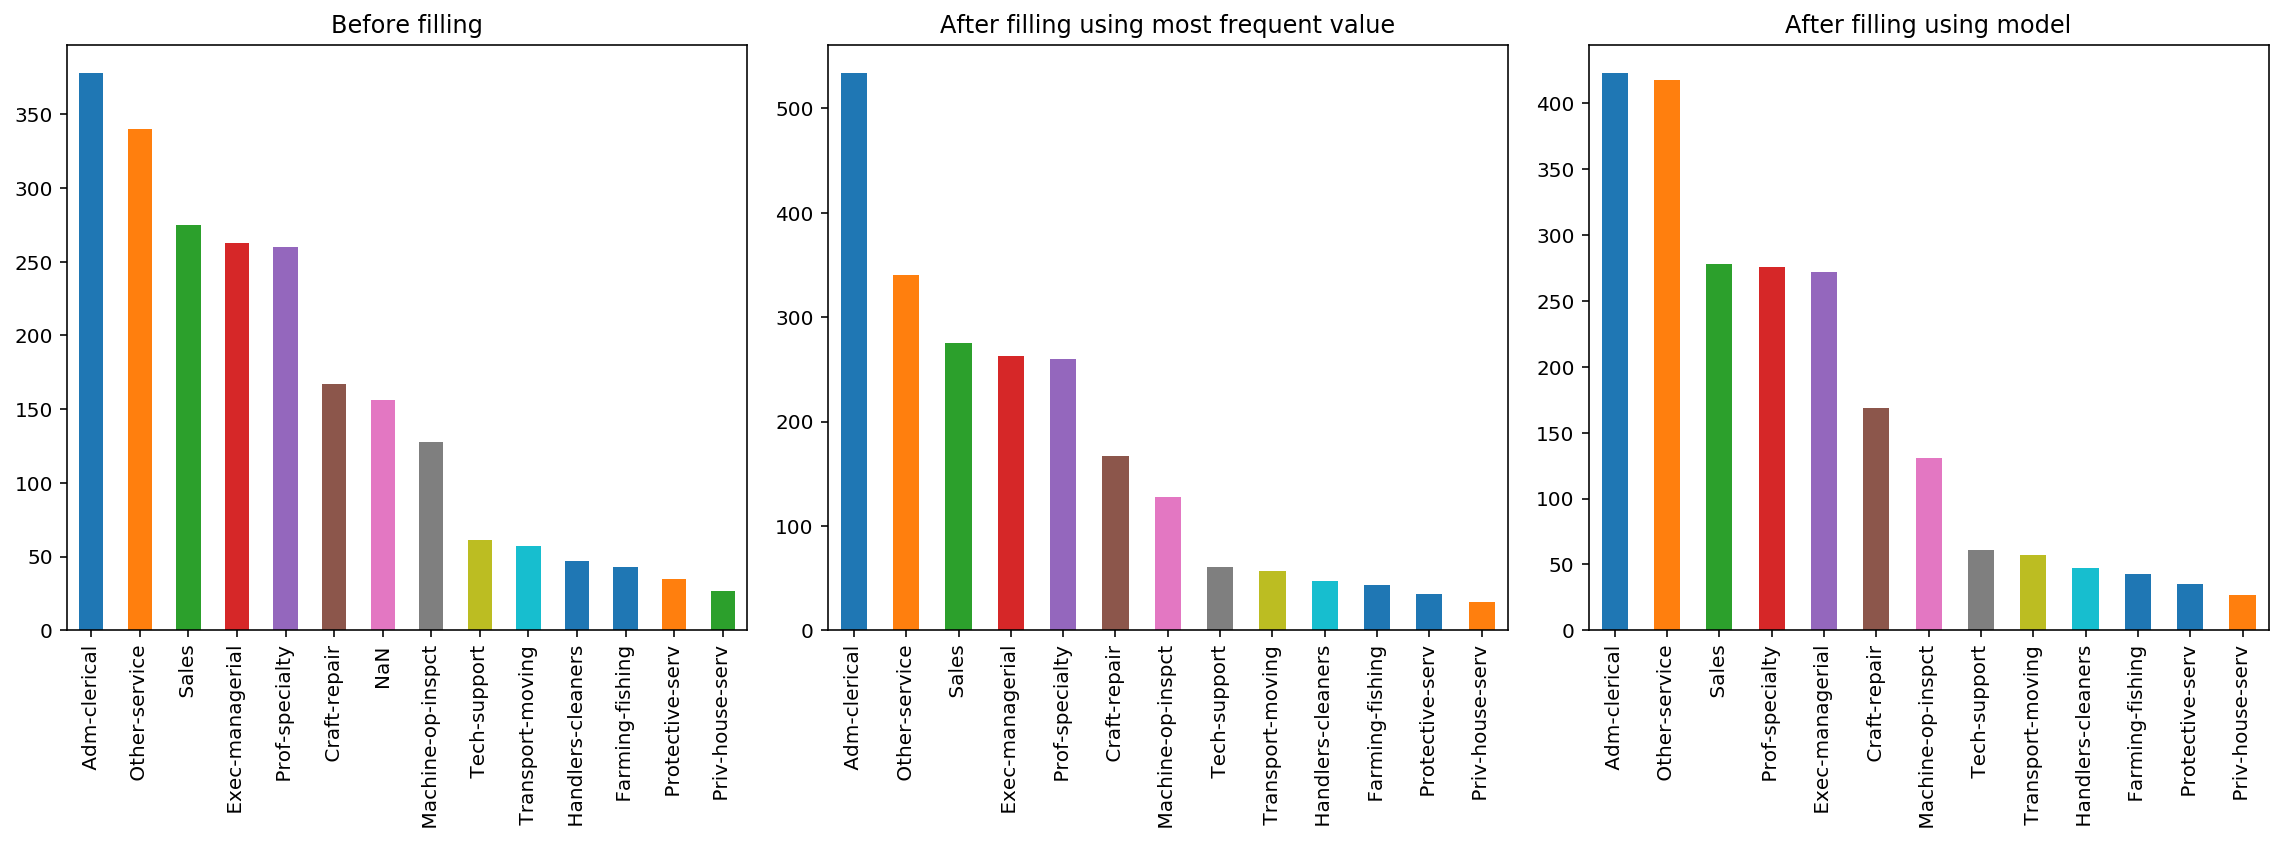

In [84]:
compare_distributions(filled_model['occupation'], filled_most_frequent['occupation'], filled_rf['occupation'])

##### pregnant

There is also *pregnant* attribute that have been chosen for filling missing values. As we can see from plots below, filling using most frequent values and using model are almost or totally equal.

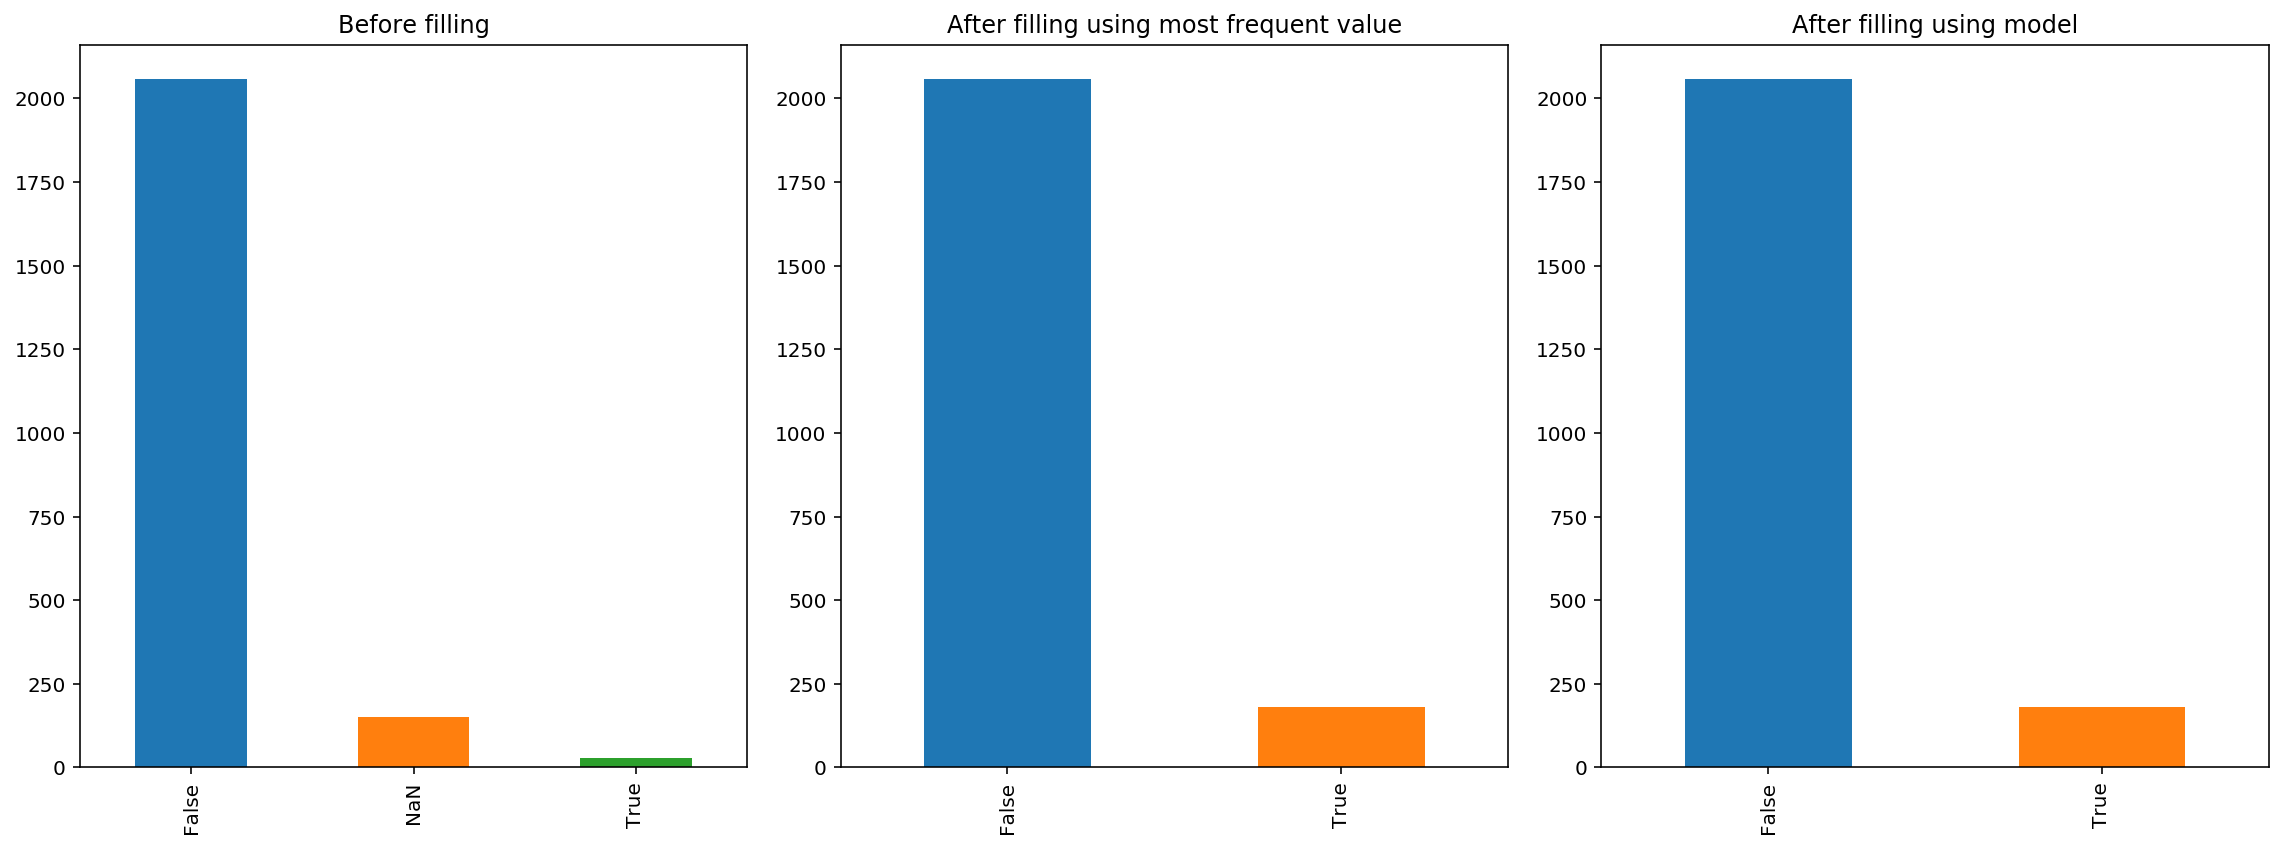

In [85]:
compare_distributions(filled_model['pregnant'], filled_most_frequent['pregnant'], filled_rf['pregnant'])

##### origin

In *origin* attribute, the same results occured as in *pregnant* attribute - no significant difference between most frequent and model filling. It is caused by majority of one category, so model learned just to predict this value very well.

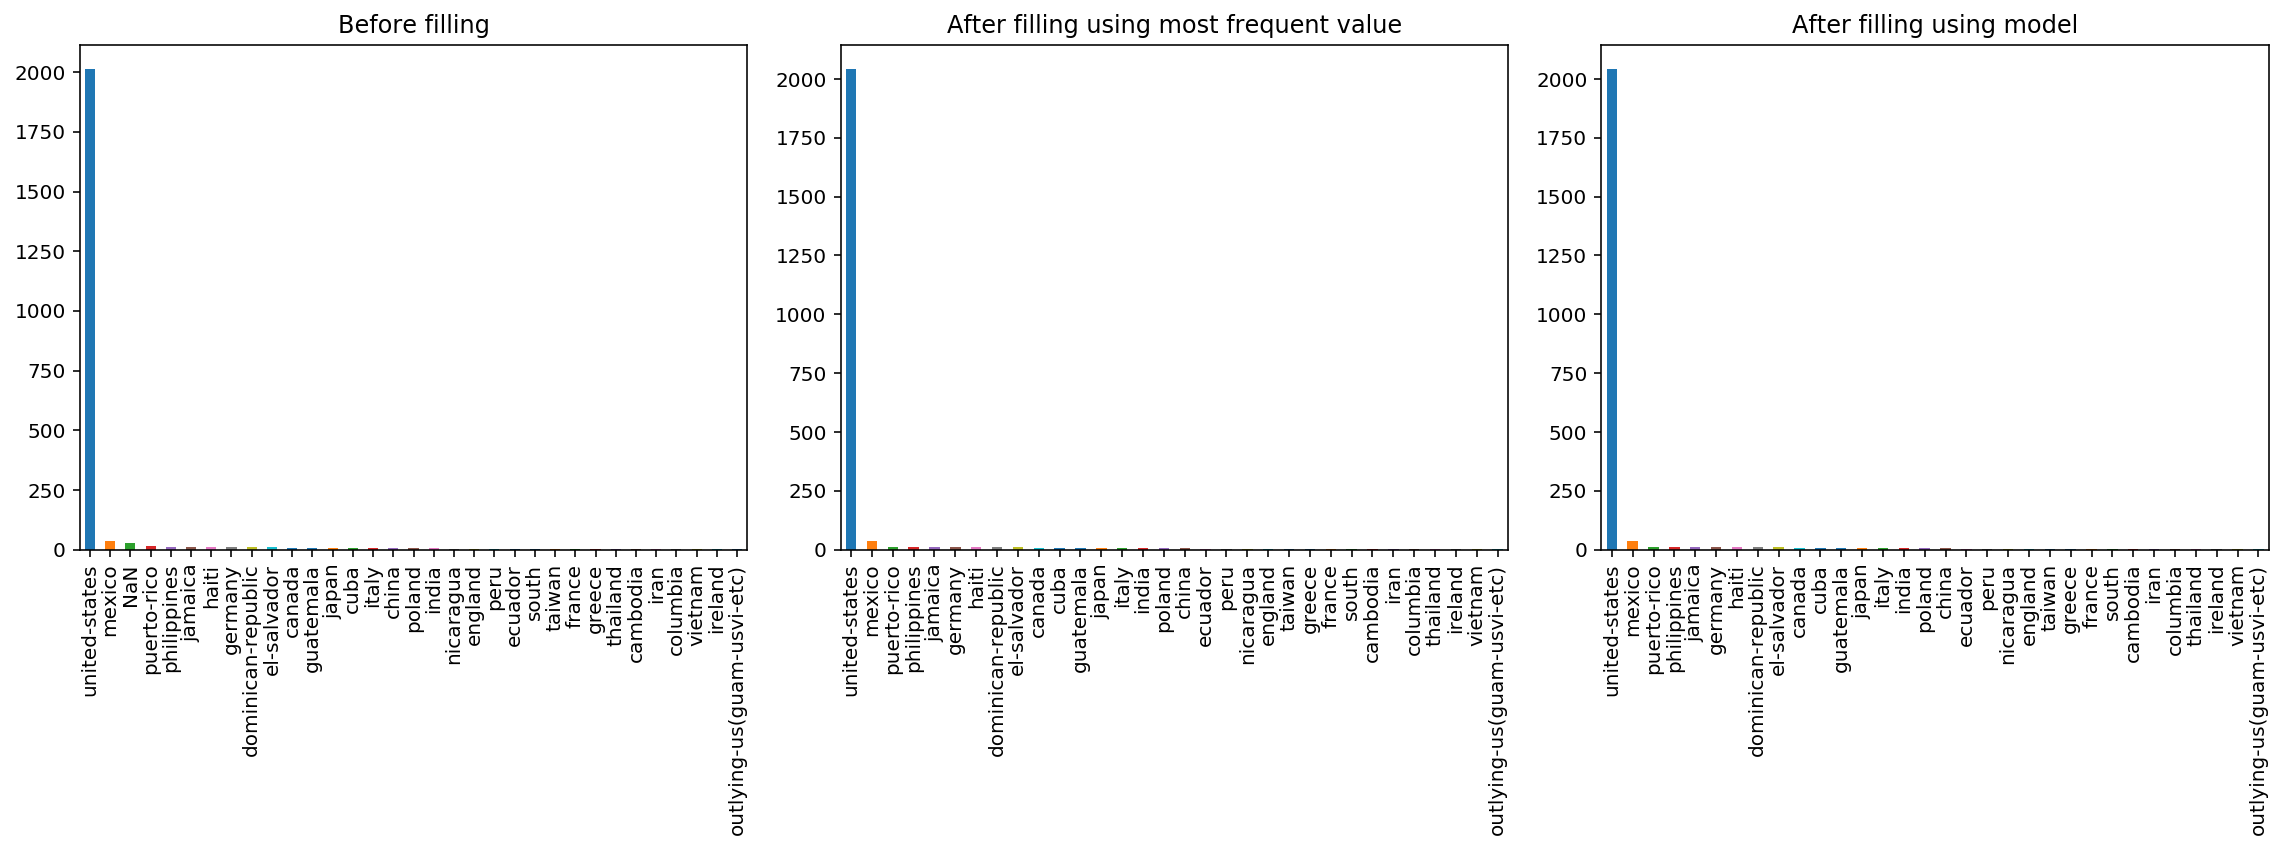

In [86]:
compare_distributions(filled_model['origin'], filled_most_frequent['origin'], filled_rf['origin'])

## Repeat analysis to see changes

A lot of changes in our data have been done. For this reason, descriptive analysis will be repeated. Some changes in the data have already been shown on graphs above. Those changes are not going to be pointed out again.

In [87]:
after_changes = filled_rf

Let's have a look at how many rows were dropped in preprocessing. It is caused by merging duplicates.

In [88]:
# Before
len(df_train)

2287

In [89]:
# After
len(after_changes)

2237

Let's check how many records were stored in dataset with personal info:

In [90]:
len(df1)

2237

As we can see, 50 records were merged and dropped. But number of rows after changes is equal to number of records in personal info dataset. That means, every row was preprocessed but never dropped.

Now, let's check how datatypes of attributes have changed:

In [91]:
after_changes.dtypes

index                          int64
name                          object
address                       object
age                          float64
sex                           object
date_of_birth                 object
query hyperthyroid            object
T4U measured                    bool
FTI measured                    bool
lithium                       object
TT4                          float64
T4U                          float64
capital-loss                 float64
capital-gain                 float64
query hypothyroid             object
on thyroxine                  object
tumor                         object
TSH                          float64
T3                           float64
fnlwgt                       float64
FTI                          float64
hours-per-week               float64
sick                          object
thyroid surgery               object
workclass                     object
I131 treatment                object
TT4 measured                    bool
c

In comparison to previous analysis, some columns were assigned boolean datatype. This is the case of columns with flag if was measurement done or not and other columns with True or False values. There are also missing *TBG* and *TBG measured* columns that were dropped in preprocessing because they did not hold any information. New columns were added while expanding column *personal_info*. Column *FTI* was object before, now it is numerical attribute. It is because it contained '?' as missing value.

Describing preprocessed dataframe can tell us how distributions of values have changed:

In [92]:
after_changes.describe(include='all')

,index,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,...,education-num,psych,occupation,pregnant,class_status,bred,origin,study,status1,status2
count,2237.000000,2237,2237,2237.000000,2237,2236,2237,2237,2237,2237,...,2237.000000,2237,2237,2237,2237,2237,2237,2237,2237,2237
unique,NaN,2236,2237,NaN,2,2123,2,2,2,2,...,NaN,2,13,2,3,5,32,24,7,6
top,NaN,Terry Murphy,"55237 Daniel Oval Suite 999\r\nLake Lisafort, ...",NaN,F,03/12/1950,False,True,True,False,...,NaN,False,Adm-clerical,False,negative,white,united-states,hs-grad,never-married,not-in-family
freq,NaN,2,1,NaN,1522,3,2101,2002,2003,2226,...,NaN,2128,423,2057,2131,1873,2041,664,887,694
mean,1121.913277,NaN,NaN,3.868271,NaN,NaN,NaN,NaN,NaN,NaN,...,2.475983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,672.057102,NaN,NaN,0.423041,NaN,NaN,NaN,NaN,NaN,NaN,...,0.761102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,2.708050,NaN,NaN,NaN,NaN,NaN,NaN,...,1.791759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,545.000000,NaN,NaN,3.583519,NaN,NaN,NaN,NaN,NaN,NaN,...,2.197225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1122.000000,NaN,NaN,3.988984,NaN,NaN,NaN,NaN,NaN,NaN,...,2.302585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1703.000000,NaN,NaN,4.204693,NaN,NaN,NaN,NaN,NaN,NaN,...,2.500192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In comparison to first analysis, a lot of values have changed because of preprocessing. Most frequent values mostly stayed the same, just their frequences have increased. In numerical attributes, changes are more significant. All aggregation functions have been changed because of normalization, outliers replacement and filling values using model.

**Not every attribute will be separately compared (its state before and after preprocessing) in this section as they have already been compared in the sections above.**

Now, let's compare missing values before and after preprocessing:

**Note:** There is one column (*date_of_birth*) that was not filled using model. The reason behind this decision is that this column contains lots of unique values and we find it hard to use model for filling in this case.

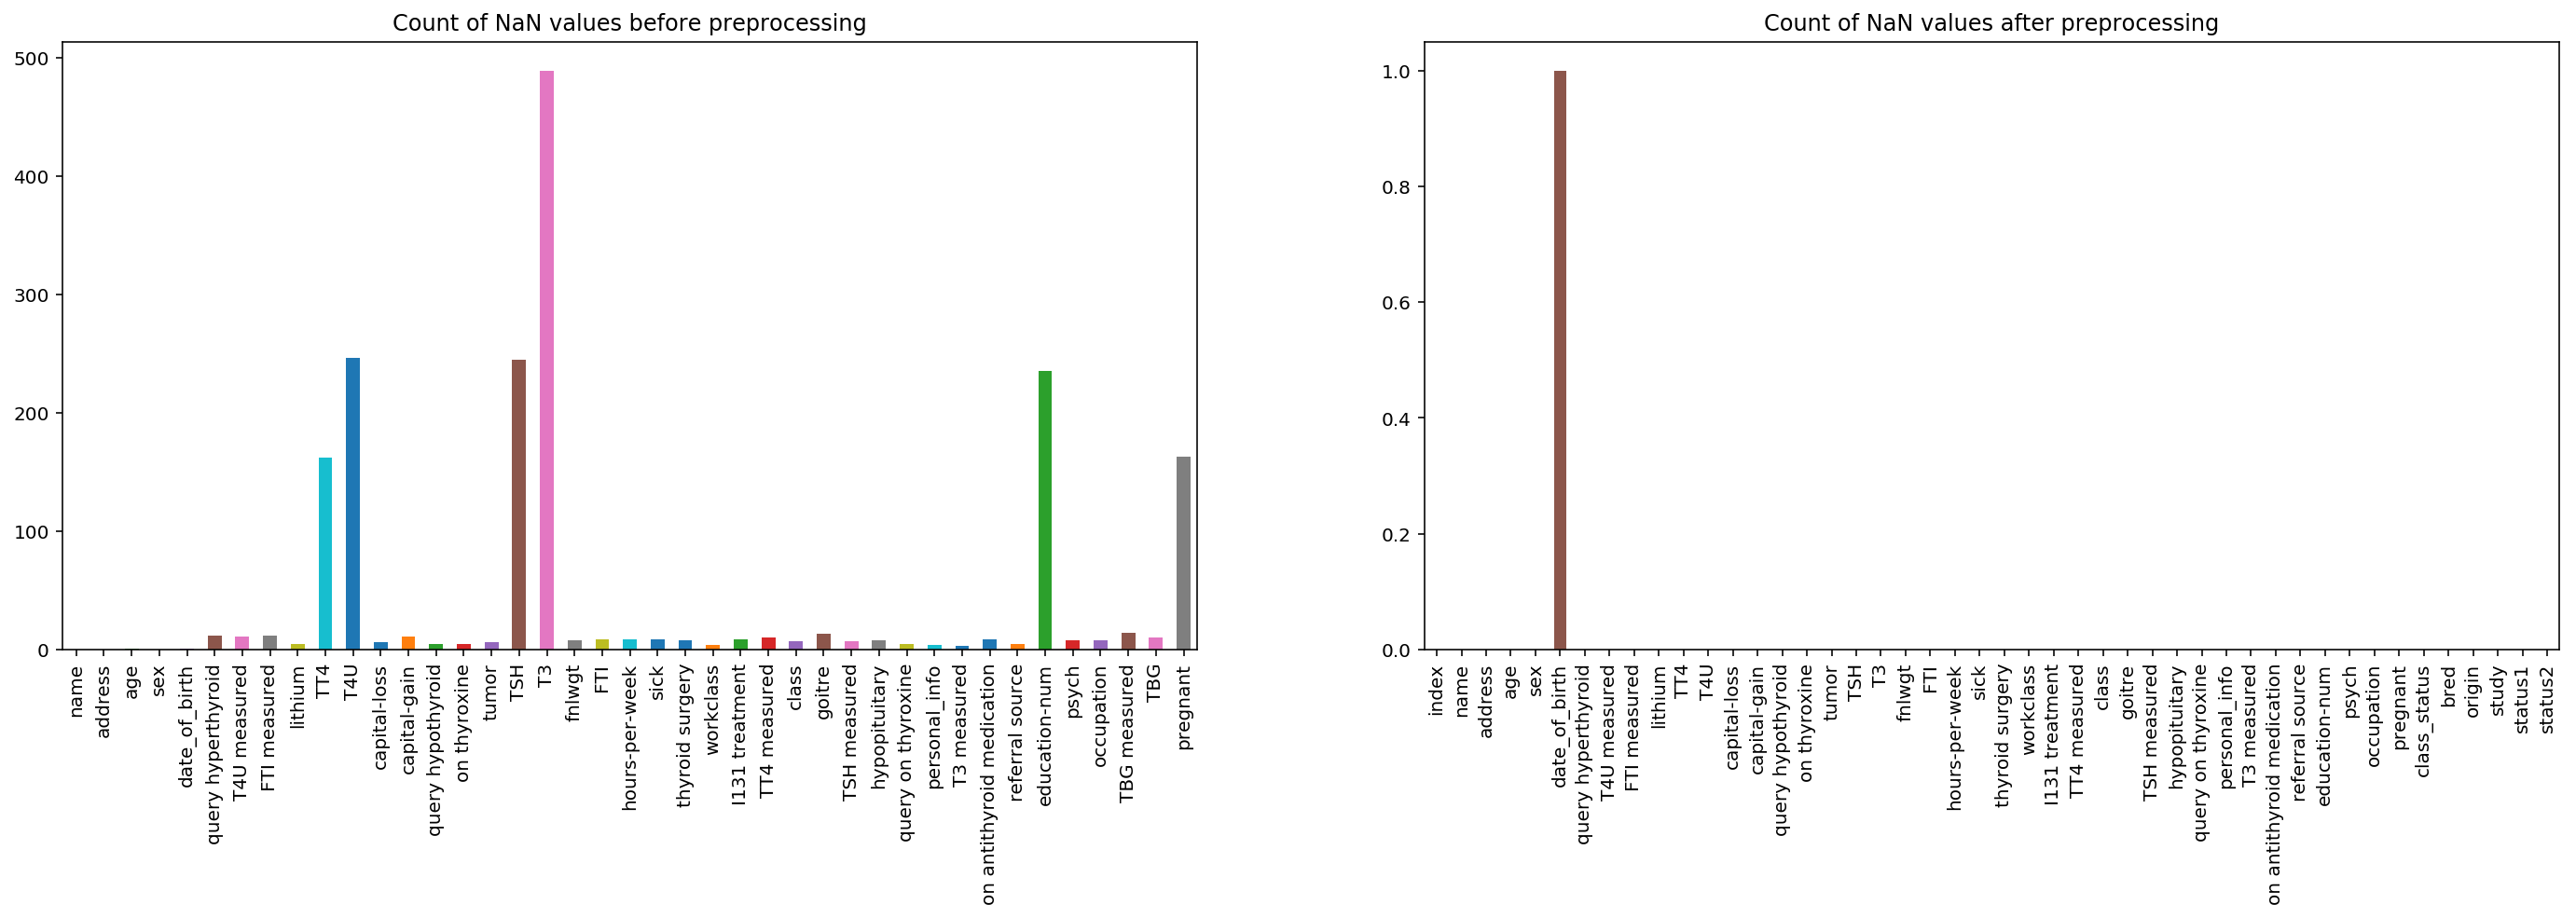

In [93]:
plt.rcParams['figure.figsize'] = (24, 6)

plt.subplot(1, 2, 1)
df_train.isnull().sum().plot(kind='bar', title='Count of NaN values before preprocessing')

plt.subplot(1, 2, 2)
after_changes.isnull().sum().plot(kind='bar', title='Count of NaN values after preprocessing')

**Note**: In the visualization on the right side, date_of_birth has a null value. It is due to visualizing dataframe which went through filling of missing values just by model. In the final pipeline, mising values of date_of_birth will be filled in using most frequent value.

Also correlations have changed. For the amount of correlations to be compared, only heatmap is shown:

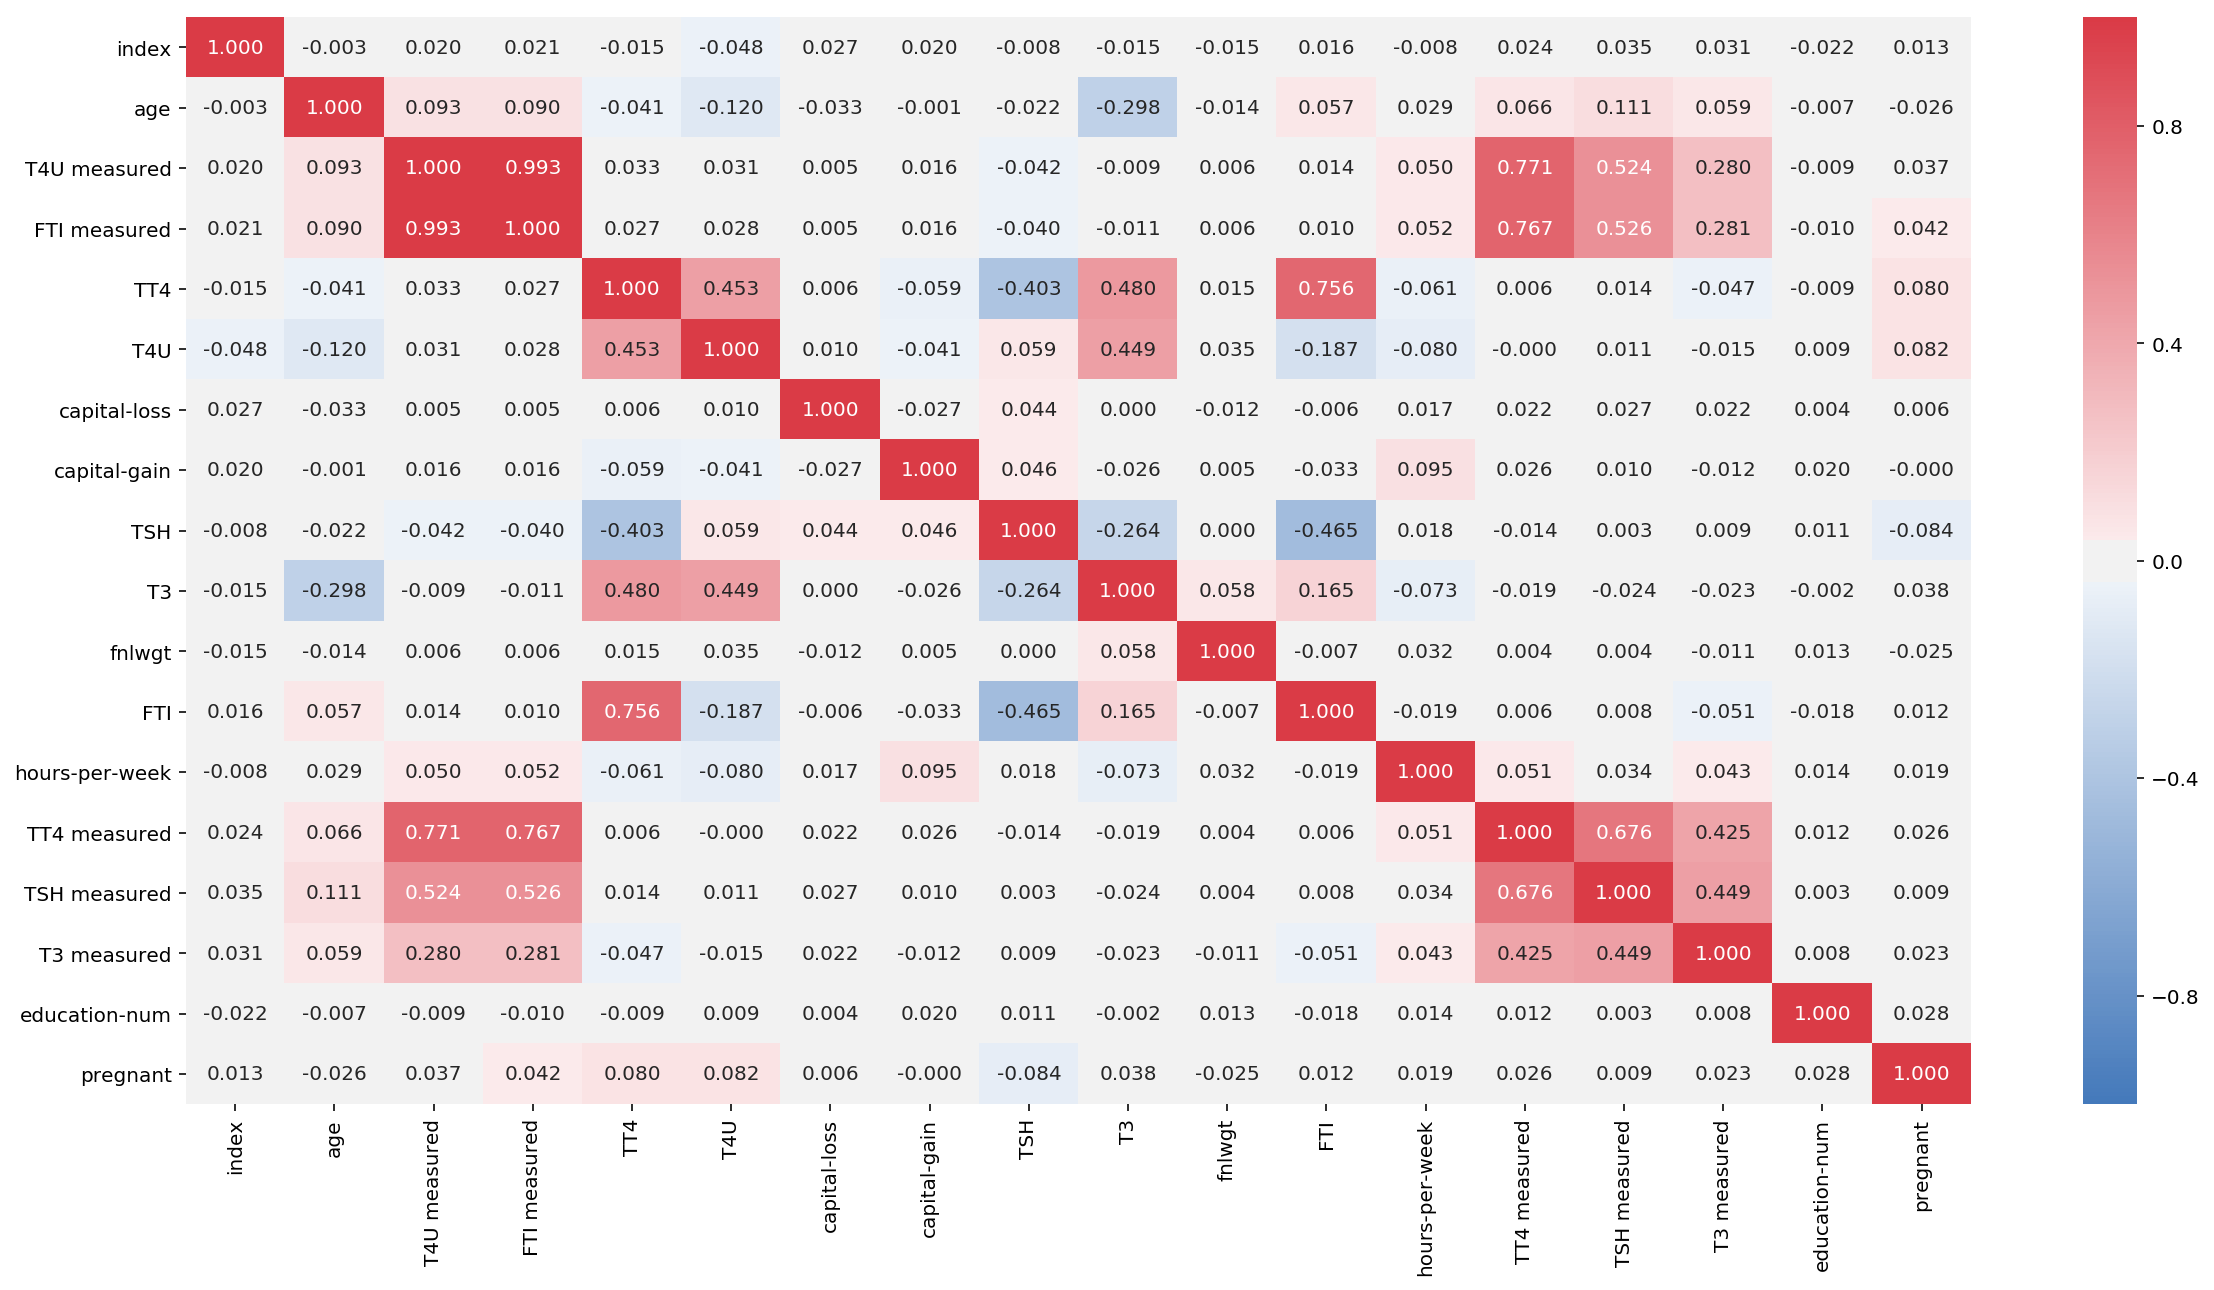

In [94]:
fig, ax = plt.subplots(figsize=(20,10))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(after_changes.corr(), annot=True, cmap=cmap, fmt=".3f", vmin=-1.0, vmax=1.0)

## Final and single pipeline dataframe preprocessing
In this section, we've defined a single pipeline executing the whole process of dataframe preprocessing. It contains selection of processes that we've executed partially in previous sections.

In [95]:
df_valid = pd.merge(df1_valid, df2_valid, on=["name", "address"])

In [96]:
# Classifiers
lr = LinearRegression()
rf = RandomForestClassifier(n_estimators=100, max_depth=7)

In [97]:
data_set_preprocessing = Pipeline([
                # Data repairing
                # ======================
                # unify boolean values
                ('unify_boolean', BooleanUnifier(['query hyperthyroid', 'T4U measured', 'on thyroxine', 'FTI measured', 'lithium', 'TT4 measured',
                                                  'query hypothyroid', 'query on thyroxine', 'tumor', 'T3 measured', 'sick', 'thyroid surgery', 
                                                  'I131 treatment', 'goitre', 'TSH measured', 'on antithyroid medication', 'psych', 'TBG measured',
                                                  'pregnant', 'hypopituitary'])),
                # unify class format
                ('class_unifier', ClassUnifier()),

                # unify date format
                ('date_unifier', DateFormatUnifier('date_of_birth')),

                # drop column
                ('drop_TBG_measured', DropColumn('TBG measured')),
                ('drop_TBG', DropColumn('TBG')),

                # measured columns fix
                ('fix_measured_values',MeasuredValuesFixer(['T4U', 'FTI', 'TT4', 'TT4','TSH','T3'])),

                # expand column
                ('expand_personal_info', ColumnExpander()),

                # unify nan values
                ('nan_unify_FTI', NanUnifier(['FTI', 'sex', 'origin', 'occupation'])),

                # transform data type
                ('column_to_number_FTI', ColumnToNumber('FTI')),

                # merge and remove duplicates
                ('rm_duplicates', MergeRemoveDuplicates()),
                
                # drop, where are nan values
                ('drop_class', DropRowsNanColumn('class')),
                # ======================

                # Data normalization
                # ======================
                ('norm_numerical', Normalizer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Outliers replacement
                # ======================
                ('reout_numerical', OutliersReplacer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Filling numerical values by Linear Regression
                # ======================
                ('flr_T4U', NumModelFiller('T4U', lr)),
                ('flr_TT4', NumModelFiller('TT4', lr)),
                ('flr_T3', NumModelFiller('T3', lr)),
                ('flr_TSH', NumModelFiller('TSH', lr)),
                ('flr_FTI', NumModelFiller('FTI', lr)),
                ('flr_age', NumModelFiller('age', lr)),
                ('flr_education_num', NumModelFiller('education-num', lr)),
                ('flr_fnlwgt', NumModelFiller('fnlwgt', lr)),
                ('flr_capital_loss', NumModelFiller('capital-loss', lr)),
                ('flr_capital_gain', NumModelFiller('capital-gain', lr)),
                ('flr_hours_per_week', NumModelFiller('hours-per-week', lr)),
                # ======================

                # Filling categorical values by RF
                # ======================
                ('fill_rf_sex', CategoricalModelFiller('sex', rf)),
                ('fill_rf_pregnant', CategoricalModelFiller('pregnant', rf)),
                ('fill_rf_tumor', CategoricalModelFiller('tumor', rf)),
                ('fill_rf_occupation', CategoricalModelFiller('occupation', rf)),
                ('fill_rf_origin', CategoricalModelFiller('origin', rf)),
                ('fill_rf_query_hypothyroid', CategoricalModelFiller('query hypothyroid', rf)),
                ('fill_rf_query_hyperthyroid', CategoricalModelFiller('query hyperthyroid', rf)),
                ('fill_rf_on_thyroxine', CategoricalModelFiller('on thyroxine', rf)),
                ('fill_rf_sick', CategoricalModelFiller('sick', rf)),
                ('fill_rf_thyroid_surgery', CategoricalModelFiller('thyroid surgery', rf)),
                ('fill_rf_workclass', CategoricalModelFiller('workclass', rf)),
                ('fill_rf_I131_treatment', CategoricalModelFiller('I131 treatment', rf)),
                ('fill_rf_hypopituitary', CategoricalModelFiller('hypopituitary', rf)),
                ('fill_rf_query_on_thyroxine', CategoricalModelFiller('query on thyroxine', rf)),
                ('fill_rf_on_antithyroid_medication', CategoricalModelFiller('on antithyroid medication', rf)),
                ('fill_rf_referral_source', CategoricalModelFiller('referral source', rf)),
                ('fill_rf_psych', CategoricalModelFiller('psych', rf)),
                # Filling categorical with most frequent value
                # ======================
                ('fill_mf_date_of_birth', CategoricalMostFrequentFiller(['date_of_birth'])),
                ('fill_mf_origin', CategoricalMostFrequentFiller(['origin'])),
                ('fill_mf_study', CategoricalMostFrequentFiller(['study'])),
                ('fill_mf_status1', CategoricalMostFrequentFiller(['status1'])),
                ('fill_mf_status2', CategoricalMostFrequentFiller(['status2']))
                
              ])

In [98]:
df_train_preprocessed = data_set_preprocessing.fit_transform(df_train)
df_valid_preprocessed = data_set_preprocessing.transform(df_valid)

Score for column T4U: -0.003752497544772907


Score for column TT4: -0.00446104387472141


Score for column T3: -0.07921126485177007


Score for column TSH: -1.8753495394231916


Score for column FTI: -0.003794739049152029


Score for column age: -0.1669449356284333


Score for column education-num: -0.6845836682409894


Score for column fnlwgt: -10951708199.563856


Score for column capital-loss: -133567.4557026286
Score for column capital-gain: -62578167.48161055


Score for column hours-per-week: -145.49237709519818


Score for column sex: 0.7156693794424722


Score for column pregnant: 0.9860897635926239


Score for column tumor: 0.9758685137732224


Score for column occupation: 0.27769143104016725


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Score for column origin: 0.8630271848352751


Score for column query hypothyroid: 0.8714901327496618


Score for column query hyperthyroid: 0.8759826944978292


Score for column on thyroxine: 0.8855707256744252


Score for column sick: 0.903265134529148


Score for column thyroid surgery: 0.9861446277315112


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Score for column workclass: 0.7153235626217416


Score for column I131 treatment: 0.9238227987757135


Score for column hypopituitary: 1.0


Score for column query on thyroxine: 0.9251541479820629


Score for column on antithyroid medication: 0.9879344170403586


Score for column referral source: 0.6428231162475988


Score for column psych: 0.9512770457837721


Let's check how our data look like after preprocessing:

In [99]:
df_train_preprocessed.head()

,index,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,...,education-num,psych,occupation,pregnant,class_status,bred,origin,study,status1,status2
0,0,Terry Terry,"11818 Lori Crossing Apt. 802\r\nPughstad, DC 7...",4.143135,M,12/09/1955,False,False,False,False,...,2.197225,False,Transport-moving,False,negative,white,united-states,hs-grad,divorced,unmarried
1,1,Edith Boudreaux,"PSC 4657, Box 5446\r\nAPO AP 58412",4.290459,F,30/04/1945,False,True,True,False,...,2.453098,False,Prof-specialty,False,negative,white,united-states,bachelors,never-married,own-child
2,2,Janet Washington,Unit 9759 Box 9470\r\nDPO AP 45549,4.304065,F,06/06/1944,False,True,True,False,...,2.536116,False,Craft-repair,False,negative,white,united-states,hs_grad,divorced,unmarried
3,3,Margaret Chabot,"137 Lewis Flat Suite 762\r\nWest Elizabeth, AL...",3.891820,F,01/10/1969,False,True,True,False,...,2.302585,False,Adm-clerical,False,negative,white,united-states,some-college,divorced,unmarried
4,4,Colleen Satterwhite,"995 Frank Stravenue\r\nSouth Matthewport, TX 8...",2.995732,F,08/01/2016,False,True,True,False,...,2.197225,False,Other-service,False,negative,black,united-states,hs-grad,never-married,unmarried


In [100]:
df_valid_preprocessed.head()

,index,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,...,education-num,psych,occupation,pregnant,class_status,bred,origin,study,status1,status2
0,0,Frances Pryor,"55866 Nicholson View\r\nTraviston, LA 41078",3.401197,F,12/07/1988,False,True,True,False,...,2.197225,False,Sales,True,increased binding protein,white,united-states,hs-grad,widowed,unmarried
1,1,Bernadette Depaolo,"68243 Nathan Pines Suite 570\r\nChristinaberg,...",3.367296,F,07/10/1989,True,True,True,False,...,45587.604406,False,Craft-repair,True,negative,white,united-states,hs-grad,divorced,not-in-family
2,2,Gloria Lepley,"876 Nancy Flats Suite 185\r\nLake Carolynton, ...",3.496508,F,23/05/1985,False,False,False,False,...,-222888.110182,False,Craft-repair,False,negative,black,united-states,bachelors,divorced,not-in-family
3,3,Esther Beaty,"36893 Garcia Walk Apt. 689\r\nBelindastad, AR ...",2.944439,F,24/04/1999,False,True,True,False,...,2.197225,False,Sales,False,negative,white,united-states,hs-grad,separated,unmarried
4,6,Elizabeth Waters,"4677 Cody Shoal\r\nBergertown, MD 75030",4.248495,F,30/11/1947,False,True,True,False,...,2.564949,False,Adm-clerical,False,negative,white,united-states,bachelors,divorced,not-in-family


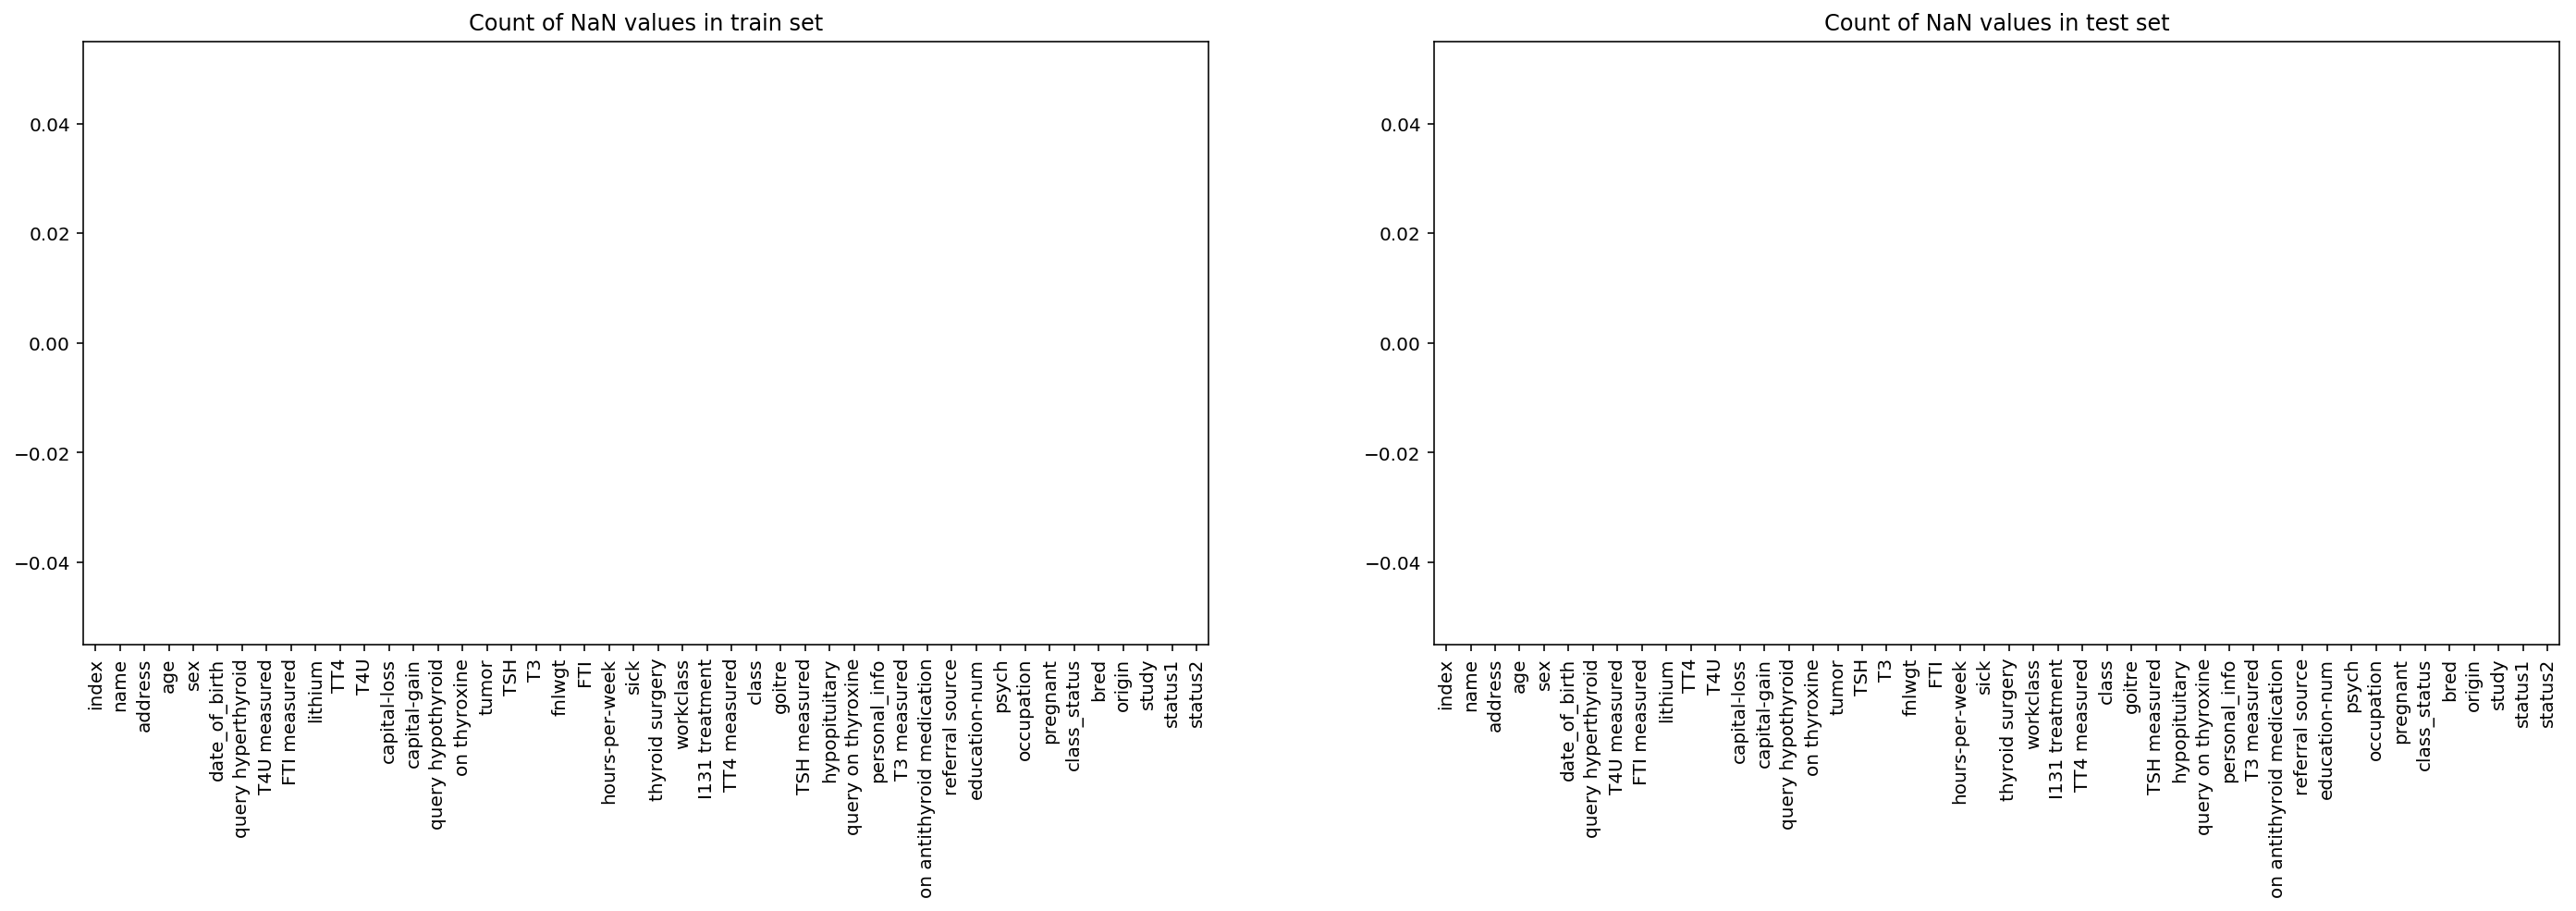

In [101]:
plt.rcParams['figure.figsize'] = (24, 6)

plt.subplot(1, 2, 1)
df_train_preprocessed.isnull().sum().plot(kind='bar', title='Count of NaN values in train set')

plt.subplot(1, 2, 2)
df_valid_preprocessed.isnull().sum().plot(kind='bar', title='Count of NaN values in test set')

For process of preprocessing, **Pipelines** have been used. Pipelines made preprocessing easily reusable and gave us ability to separate fitting of training set and transformation of training and testing set. For those advantages we consider pipelines the best tool for preprocessing.